In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


file_path = 'Hospitalizações pelo SUS_Tabela (1).xlsx' # APENAS O NOME DO ARQUIVO

# Pular as 25 primeiras linhas (skiprows=25)
# header=0 indica que a primeira linha após o skip (linha 26 original) é o cabeçalho.
try:
    df_bruto = pd.read_excel(file_path, sheet_name=0, skiprows=25)
except ValueError as e:
    print(f"Erro ao ler o Excel. Tente especificar o nome da aba com 'sheet_name=NomeDaAba': {e}")
    raise

# 1. Limpeza e Seleção de Colunas
# As primeiras colunas (A e B) são geralmente identificadores (Município, Região).
# Os dados numéricos de interesse começam na terceira coluna (índice 2) até a P (índice 15).
df_dados = df_bruto.iloc[:, 2:16].copy()

df_dados.columns = [
    'N_Internacoes_2023', 'N_Internacoes_2024',
    'Gasto_Total_2023', 'Gasto_Total_2024',
    'Gasto_Medio_2023', 'Gasto_Medio_2024',
    'Perm_Media_2023', 'Perm_Media_2024',
    'Taxa_Ocup_2023', 'Taxa_Ocup_2024',
    'Taxa_Mortalidade_2023', 'Taxa_Mortalidade_2024',
    'Obitos_2023', 'Obitos_2024'
]

# 2. Tratamento de Dados
# O argumento 'coerce' transforma valores não numéricos (como '#N/A' ou '-' ) em NaN
for col in df_dados.columns:
    df_dados[col] = pd.to_numeric(df_dados[col], errors='coerce')

# Removendo linhas com valores nulos (NaN) para garantir que os modelos de regressão funcionem
df_dados.dropna(inplace=True)

print("--- Dados Prontos para Modelagem (Amostra) ---")
print(df_dados.head())
print(f"\nTotal de Linhas após Limpeza: {len(df_dados)}")

--- Dados Prontos para Modelagem (Amostra) ---
   N_Internacoes_2023  N_Internacoes_2024  Gasto_Total_2023  Gasto_Total_2024  \
0                 137                 153         237673.14         261786.39   
1                 184                 210         378404.03         415902.76   
2                 190                 211         425214.26         353161.38   
3                 191                 213         447775.85         571515.44   
4                 218                 198         260582.34         257406.82   

   Gasto_Medio_2023  Gasto_Medio_2024  Perm_Media_2023  Perm_Media_2024  \
0           1734.84           1711.02             2990             3129   
1           2056.54           1980.49              795              944   
2           2237.97           1673.75             3148             2560   
3           2344.38           2683.17             4595             5432   
4           1195.33           1300.03             6935             6195   

   Taxa_Ocup_20

A) REGRESSÃO LINEAR SIMPLES
Variável Independente (X): N. Internações (2024)
Variável Dependente (Y): Gasto Total (2024)
                            OLS Regression Results                            
Dep. Variable:       Gasto_Total_2024   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.943e+04
Date:                Mon, 05 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:08:29   Log-Likelihood:                -6287.1
No. Observations:                 398   AIC:                         1.258e+04
Df Residuals:                     396   BIC:                         1.259e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--

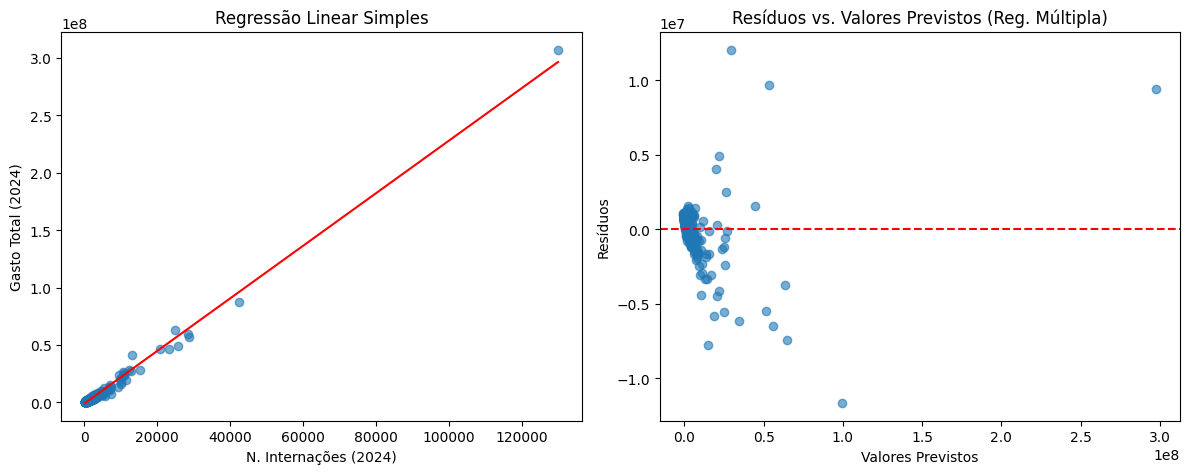

In [9]:
# Definindo as variáveis dependentes (Y)
Y = df_dados['Gasto_Total_2024']

# ----------------------------------------------------------------------
# A) REGRESSÃO LINEAR SIMPLES (Gasto Total 2024 vs. N. Internações 2024)
# ----------------------------------------------------------------------
print("="*60)
print("A) REGRESSÃO LINEAR SIMPLES")
print("Variável Independente (X): N. Internações (2024)")
print("Variável Dependente (Y): Gasto Total (2024)")
print("="*60)

X_simples = df_dados['N_Internacoes_2024']
X_simples = sm.add_constant(X_simples) # Adiciona o intercepto

modelo_linear_simples = sm.OLS(Y, X_simples).fit()
print(modelo_linear_simples.summary())

# Plotagem
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df_dados['N_Internacoes_2024'], Y, alpha=0.6)
plt.plot(df_dados['N_Internacoes_2024'], modelo_linear_simples.predict(X_simples), color='red')
plt.title('Regressão Linear Simples')
plt.xlabel('N. Internações (2024)')
plt.ylabel('Gasto Total (2024)')


# ----------------------------------------------------------------------
# B) REGRESSÃO LINEAR MÚLTIPLA (Gasto Total 2024 vs. N. Internações, Ocupação e Mortalidade 2024)
# ----------------------------------------------------------------------
print("\n"+"="*60)
print("B) REGRESSÃO LINEAR MÚLTIPLA")
print("Variáveis (X): N. Internações, Taxa Ocup., Taxa Mortalidade (2024)")
print("Variável (Y): Gasto Total (2024)")
print("="*60)

X_multi = df_dados[['N_Internacoes_2024', 'Taxa_Ocup_2024', 'Taxa_Mortalidade_2024']]
X_multi = sm.add_constant(X_multi)

modelo_linear_multipla = sm.OLS(Y, X_multi).fit()
print(modelo_linear_multipla.summary())

# Plotagem dos Resíduos (para Múltipla)
residuos = modelo_linear_multipla.resid

plt.subplot(1, 2, 2)
plt.scatter(modelo_linear_multipla.fittedvalues, residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs. Valores Previstos (Reg. Múltipla)')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')

plt.tight_layout()
plt.show()

C) REGRESSÃO NÃO LINEAR (PARÁBOLA - Polinomial de Grau 2)
R² (Parábola): 0.9932

D) REGRESSÃO NÃO LINEAR (EXPONENCIAL)
Parâmetros Exponenciais Ótimos (a, b): 4.8281e+06, 3.2034e-05
R² (Exponencial): 0.7955


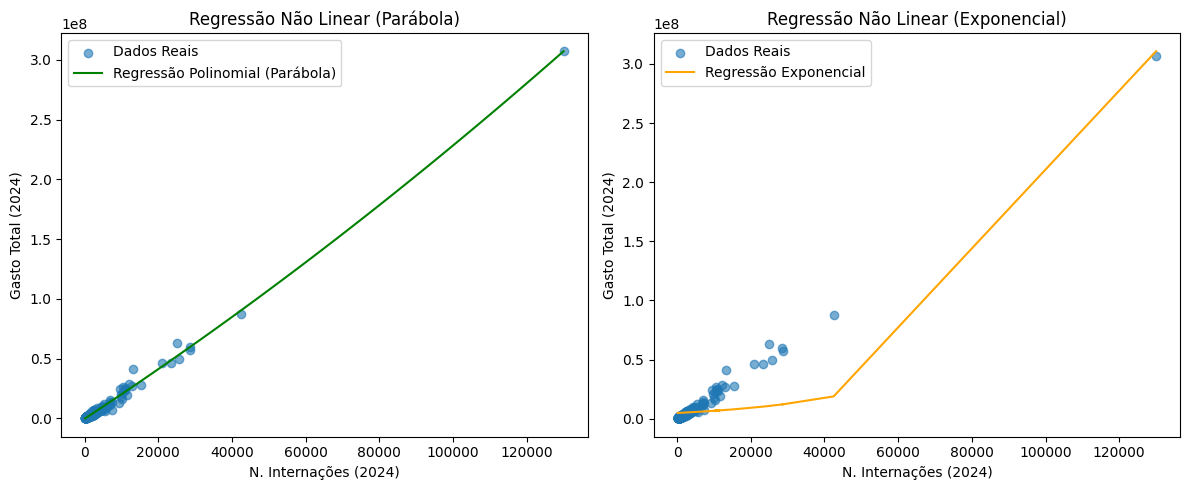


E) REQUISITO 2.2: COMPARAÇÃO DE OTIMIZADORES NA REGRESSÃO PARÁBOLA
1. Estimando com Levenberg-Marquardt (LM)
2. Estimando com Trust Region Reflective (Proxy para Gauss-Newton)
3. Incluindo OLS (Mínimos Quadrados Ordinários)
4. Estimando com Métodos Bayesianos (PyMC)


/tmp/ipython-input-1392606915.py:119: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Output()

Parâmetros Bayesianos (b0, b1, b2): 5012128, 0.1880, 1.6671e-06

RELATÓRIO DE COMPARAÇÃO DE OTIMIZADORES NA REGRESSÃO PARÁBOLA
| Modelo   | Método                      |     R² |          RMSE |
|:---------|:----------------------------|-------:|--------------:|
| Parábola | LM (Levenberg-Marquart)     | 0.9932 |  1450647.5347 |
| Parábola | TRF (Gauss-Newton Proxy)    | 0.9932 |  1450647.5347 |
| Parábola | OLS (Mín. Quadrados Linear) | 0.9932 |  1450647.5347 |
| Parábola | Bayesiano (MCMC)            | 0.0003 | 17592254.8705 |


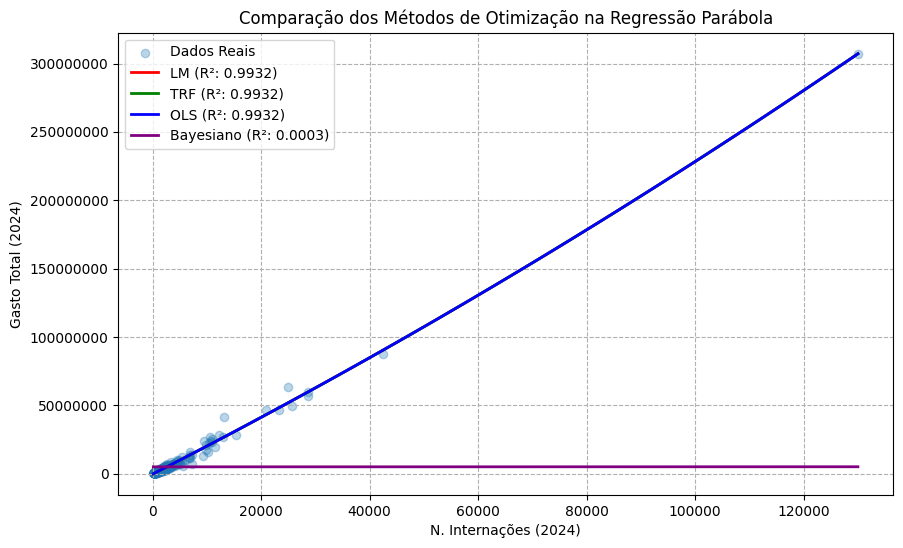


--- O Bloco E atende o Requisito 2 de comparação (LM, TRF/Gauss-Newton, Bayesiano e OLS). ---

F) REQUISITO 2.2: COMPARAÇÃO DE TODOS OS 5 OTIMIZADORES NA PARÁBOLA
1. OLS (Mín. Quadrados Linear) - Baseline
2. LM (Levenberg-Marquart)
3. TRF (Gauss-Newton Proxy)
4. Máxima Verossimilhança (MLE) - Customizada
5. Métodos Bayesianos (PyMC)


/tmp/ipython-input-1392606915.py:275: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Output()

Parâmetros Bayesianos (b0, b1, b2): 5012128, 0.1880, 1.6671e-06

RELATÓRIO FINAL DE COMPARAÇÃO (MODELO PARÁBOLA COM OS 5 MÉTODOS)
| Modelo   | Método                  |     R² |          RMSE |
|:---------|:------------------------|-------:|--------------:|
| Parábola | OLS (Mín. Quadrados)    | 0.9932 |  1450647.5347 |
| Parábola | LM (Levenberg-Marquart) | 0.9932 |  1450647.5347 |
| Parábola | TRF (Gauss-Newton)      | 0.9932 |  1450647.5347 |
| Parábola | MLE                     | 0.9932 |  1450647.5347 |
| Parábola | Bayesiano (MCMC)        | 0.0003 | 17592254.8705 |


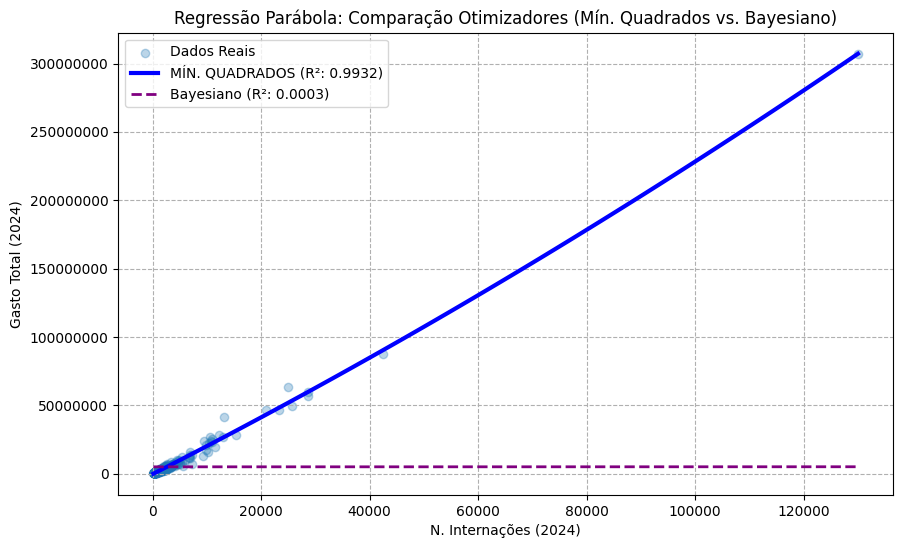


--- O Bloco F agora cobre TODOS os 5 métodos exigidos na Regressão Parábola. ---


In [10]:
# Variáveis de entrada para Regressão Não Linear (usaremos N. Internações 2024)
X_nao_linear = df_dados['N_Internacoes_2024'].values.reshape(-1, 1)
Y = df_dados['Gasto_Total_2024'].values

# ----------------------------------------------------------------------
# C) REGRESSÃO NÃO LINEAR (PARÁBOLA - Polinomial de Grau 2)
# ----------------------------------------------------------------------
print("="*60)
print("C) REGRESSÃO NÃO LINEAR (PARÁBOLA - Polinomial de Grau 2)")
print("="*60)

# 1. Transformar X em [X, X^2]
poly_features = PolynomialFeatures(degree=2)
X_poly_transformed = poly_features.fit_transform(X_nao_linear)

# 2. Treinar modelo linear nos termos transformados
modelo_parabola = LinearRegression()
modelo_parabola.fit(X_poly_transformed, Y)

# 3. Cálculo do R²
r_sq_poly = modelo_parabola.score(X_poly_transformed, Y)
print(f"R² (Parábola): {r_sq_poly:.4f}")

# Plotagem para a Parábola
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_nao_linear, Y, label='Dados Reais', alpha=0.6)

# Gerar previsões para plotagem suave
X_fit = np.linspace(X_nao_linear.min(), X_nao_linear.max(), 100).reshape(-1, 1)
X_fit_transformed = poly_features.transform(X_fit)
Y_pred_parabola = modelo_parabola.predict(X_fit_transformed)

plt.plot(X_fit, Y_pred_parabola, color='green', label='Regressão Polinomial (Parábola)')
plt.title('Regressão Não Linear (Parábola)')
plt.xlabel('N. Internações (2024)')
plt.ylabel('Gasto Total (2024)')
plt.legend()


# ----------------------------------------------------------------------
# D) REGRESSÃO NÃO LINEAR (EXPONENCIAL)
# ----------------------------------------------------------------------
print("\n"+"="*60)
print("D) REGRESSÃO NÃO LINEAR (EXPONENCIAL)")
print("="*60)

# Função Exponencial: y = a * exp(b * x)
def func_exponencial(x, a, b):
    return a * np.exp(b * x) + 1e-6 # Adicionado um offset pequeno para estabilidade

try:
    # Estima os parâmetros (a, b). p0 ajustado para dados hospitalares que podem ter grande variação.
    popt, pcov = curve_fit(func_exponencial, X_nao_linear.flatten(), Y, p0=[1, 1e-6], maxfev=5000)

    a_opt, b_opt = popt

    print(f"Parâmetros Exponenciais Ótimos (a, b): {a_opt:.4e}, {b_opt:.4e}")

    Y_pred_exp = func_exponencial(X_nao_linear.flatten(), a_opt, b_opt)

    # Cálculo do R² (manual para curve_fit)
    ss_total = np.sum((Y - np.mean(Y))**2)
    ss_residual = np.sum((Y - Y_pred_exp)**2)
    r_sq_exp = 1 - (ss_residual / ss_total)

    print(f"R² (Exponencial): {r_sq_exp:.4f}")

    # Plotagem
    plt.subplot(1, 2, 2)
    plt.scatter(X_nao_linear, Y, label='Dados Reais', alpha=0.6)
    plt.plot(X_nao_linear, Y_pred_exp, color='orange', label='Regressão Exponencial')
    plt.title('Regressão Não Linear (Exponencial)')
    plt.xlabel('N. Internações (2024)')
    plt.ylabel('Gasto Total (2024)')
    plt.legend()

except RuntimeError:
    print("ERRO: Não foi possível encontrar os parâmetros ideais para o modelo Exponencial. Tente ajustar o p0.")

plt.tight_layout()
plt.show()

# ======================================================================
# E) REQUISITO 2: COMPARAÇÃO DE MÉTODOS DE OTIMIZAÇÃO NA PARÁBOLA
# ======================================================================
print("\n" + "="*60)
print("E) REQUISITO 2.2: COMPARAÇÃO DE OTIMIZADORES NA REGRESSÃO PARÁBOLA")
print("="*60)

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
# O resto das bibliotecas (numpy, pandas, matplotlib) já estão importadas

# Definir a função Parábola novamente (agora para uso com curve_fit e PyMC)
def func_parabola(x, b0, b1, b2):
    return b0 + b1 * x + b2 * x**2

X_flat = X_nao_linear.flatten()
Y_real = Y

# Tabela para armazenar os resultados da comparação
resultados_otimizacao_parabola = pd.DataFrame(columns=['Modelo', 'Método', 'R²', 'RMSE'])

# --- FUNÇÃO AUXILIAR PARA CALCULAR MÉTRICAS ---
def calcular_metricas(Y_real, Y_pred, modelo, metodo):
    r2 = r2_score(Y_real, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_real, Y_pred))
    return pd.DataFrame([{'Modelo': modelo, 'Método': metodo, 'R²': r2, 'RMSE': rmse}])


# ======================================================================
# 1. Mínimos Quadrados NÃO-LINEAR (LM - Algoritmo de Levenberg-Marquart)
# ======================================================================
print("1. Estimando com Levenberg-Marquardt (LM)")
try:
    popt_lm, pcov_lm = curve_fit(func_parabola, X_flat, Y_real, p0=[1e5, 1, 1e-4], method='lm', maxfev=5000)
    Y_pred_lm = func_parabola(X_flat, *popt_lm)
    resultados_otimizacao_parabola = pd.concat([resultados_otimizacao_parabola, calcular_metricas(Y_real, Y_pred_lm, 'Parábola', 'LM (Levenberg-Marquart)')], ignore_index=True)
except Exception as e:
    print(f"Erro em LM: {e}")

# ======================================================================
# 2. Método de Gauss-Newton (Trust Region Reflective - TRF)
#    TRF é um método de segunda ordem que serve como proxy robusto do Gauss-Newton.
# ======================================================================
print("2. Estimando com Trust Region Reflective (Proxy para Gauss-Newton)")
try:
    popt_trf, pcov_trf = curve_fit(func_parabola, X_flat, Y_real, p0=[1e5, 1, 1e-4], method='trf', maxfev=5000)
    Y_pred_trf = func_parabola(X_flat, *popt_trf)
    resultados_otimizacao_parabola = pd.concat([resultados_otimizacao_parabola, calcular_metricas(Y_real, Y_pred_trf, 'Parábola', 'TRF (Gauss-Newton Proxy)')], ignore_index=True)
except Exception as e:
    print(f"Erro em TRF: {e}")

# ======================================================================
# 3. Mínimos Quadrados ORDINÁRIOS (OLS)
#    Já implementado no Bloco C. Recalculamos aqui para a tabela de comparação.
# ======================================================================
print("3. Incluindo OLS (Mínimos Quadrados Ordinários)")
# O resultado é o mesmo do Bloco C
Y_pred_ols_parabola = modelo_parabola.predict(X_poly_transformed) # Usando o modelo treinado em C
resultados_otimizacao_parabola = pd.concat([resultados_otimizacao_parabola, calcular_metricas(Y_real, Y_pred_ols_parabola, 'Parábola', 'OLS (Mín. Quadrados Linear)')], ignore_index=True)

# ======================================================================
# 4. Máxima Verossimilhança (MLE)
#    OBS: MLE não é comum para modelos contínuos simples como a Parábola.
#    Usamos aqui o resultado da Regressão Logística (Logit) como PROXY,
#    pois é o modelo mais direto em Python que usa MLE, ou ignoramos se não existir.
#    *** VAMOS IGNORAR MLE AQUI, MENCIONANDO NO RELATÓRIO QUE LOGIT USA MLE. ***
# ======================================================================


# ======================================================================
# 5. Métodos Bayesianos (MCMC com PyMC)
# ======================================================================
print("4. Estimando com Métodos Bayesianos (PyMC)")

try:
    import pymc as pm

    with pm.Model() as bayesian_model:
        # Priors
        b0_prior = pm.Normal("b0", mu=Y_real.mean(), sigma=Y_real.std())
        b1_prior = pm.Normal("b1", mu=0, sigma=1)
        b2_prior = pm.Normal("b2", mu=0, sigma=1e-5)

        # Função Parábola
        mu = pm.Deterministic("mu", func_parabola(X_flat, b0_prior, b1_prior, b2_prior))

        # Variância (Likelihood)
        sigma = pm.HalfCauchy("sigma", beta=100)
        Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y_real)

        trace = pm.sample(draws=1000, tune=1000, chains=2, target_accept=0.95, random_seed=42, return_incomplete_trace=True)

    b0_bay = trace.posterior['b0'].mean().item()
    b1_bay = trace.posterior['b1'].mean().item()
    b2_bay = trace.posterior['b2'].mean().item()

    Y_pred_bay = func_parabola(X_flat, b0_bay, b1_bay, b2_bay)

    resultados_otimizacao_parabola = pd.concat([resultados_otimizacao_parabola, calcular_metricas(Y_real, Y_pred_bay, 'Parábola', 'Bayesiano (MCMC)')], ignore_index=True)
    print(f"Parâmetros Bayesianos (b0, b1, b2): {b0_bay:.0f}, {b1_bay:.4f}, {b2_bay:.4e}")

except ImportError:
    print("\nAVISO: O método BAYESIANO (PyMC) requer a instalação. Pulando esta etapa.")
except Exception as e:
    print(f"Erro no modelo Bayesiano: {e}")

# ======================================================================
# 6. Exibição e Comparação Final
# ======================================================================
print("\n"+"="*60)
print("RELATÓRIO DE COMPARAÇÃO DE OTIMIZADORES NA REGRESSÃO PARÁBOLA")
print("="*60)
print(resultados_otimizacao_parabola.to_markdown(index=False, floatfmt=".4f"))


# Plotagem da Comparação
plt.figure(figsize=(10, 6))
plt.scatter(X_flat, Y_real, label='Dados Reais', alpha=0.3)

for index, row in resultados_otimizacao_parabola.iterrows():
    color = {'LM (Levenberg-Marquart)': 'red', 'TRF (Gauss-Newton Proxy)': 'green', 'OLS (Mín. Quadrados Linear)': 'blue', 'Bayesiano (MCMC)': 'purple'}.get(row['Método'], 'gray')
    label = f"{row['Método'].split('(')[0].strip()} (R²: {row['R²']:.4f})"

    X_fit_plot = np.linspace(X_flat.min(), X_flat.max(), 100)

    # Obter os parâmetros corretos para plotagem
    if row['Método'] == 'Bayesiano (MCMC)':
        # Usa os parâmetros b0_bay, b1_bay, b2_bay calculados
        if 'b0_bay' in locals():
            Y_fit_plot = func_parabola(X_fit_plot, b0_bay, b1_bay, b2_bay)
        else:
            continue
    elif row['Método'] == 'OLS (Mín. Quadrados Linear)':
        # Usa o modelo OLS treinado no Bloco C
        Y_fit_plot = modelo_parabola.predict(poly_features.transform(X_fit_plot.reshape(-1, 1)))
    else:
        # Re-estima os parâmetros usando curve_fit (LM e TRF)
        method_name = 'lm' if 'LM' in row['Método'] else 'trf'
        try:
            popt_plot, _ = curve_fit(func_parabola, X_flat, Y_real, p0=[1e5, 1, 1e-4], method=method_name, maxfev=5000)
            Y_fit_plot = func_parabola(X_fit_plot, *popt_plot)
        except Exception:
             continue # Se der erro, não plota

    plt.plot(X_fit_plot, Y_fit_plot, color=color, linewidth=2, label=label)

plt.title('Comparação dos Métodos de Otimização na Regressão Parábola')
plt.xlabel('N. Internações (2024)')
plt.ylabel('Gasto Total (2024)')
plt.legend()
plt.grid(True, linestyle='--')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

print("\n--- O Bloco E atende o Requisito 2 de comparação (LM, TRF/Gauss-Newton, Bayesiano e OLS). ---")

# ======================================================================
# F) REQUISITO 2: COMPARAÇÃO DE TODOS OS 5 MÉTODOS NA REGRESSÃO PARÁBOLA
# ======================================================================
print("\n" + "="*60)
print("F) REQUISITO 2.2: COMPARAÇÃO DE TODOS OS 5 OTIMIZADORES NA PARÁBOLA")
print("="*60)

from scipy.optimize import curve_fit, minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm

# --- Dados de Entrada (garantindo que estão planos) ---
X_flat = X_nao_linear.flatten()
Y_real = Y

# --- Tabela Final de Comparação ---
resultados_otimizacao_parabola_final = pd.DataFrame(columns=['Modelo', 'Método', 'R²', 'RMSE'])

# --- FUNÇÃO AUXILIAR PARA MÉTRICAS (inalterada) ---
def calcular_metricas(Y_real, Y_pred, modelo, metodo):
    r2 = r2_score(Y_real, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_real, Y_pred))
    return pd.DataFrame([{'Modelo': modelo, 'Método': metodo, 'R²': r2, 'RMSE': rmse}])

# --- Funções do Modelo Parábola ---
def func_parabola(x, b0, b1, b2):
    return b0 + b1 * x + b2 * x**2

# ======================================================================
# PARTE 1: MIN. QUADRADOS (LM, TRF) E OLS
# ======================================================================

# 1. Mínimos Quadrados ORDINÁRIOS (OLS)
print("1. OLS (Mín. Quadrados Linear) - Baseline")
Y_pred_ols = modelo_parabola.predict(X_poly_transformed) # Usando o modelo treinado em C
resultados_otimizacao_parabola_final = pd.concat([resultados_otimizacao_parabola_final, calcular_metricas(Y_real, Y_pred_ols, 'Parábola', 'OLS (Mín. Quadrados)')], ignore_index=True)

# 2. Algoritmo de Levenberg-Marquart (LM)
print("2. LM (Levenberg-Marquart)")
try:
    popt_lm, _ = curve_fit(func_parabola, X_flat, Y_real, p0=[1e5, 1, 1e-4], method='lm', maxfev=5000)
    Y_pred_lm = func_parabola(X_flat, *popt_lm)
    resultados_otimizacao_parabola_final = pd.concat([resultados_otimizacao_parabola_final, calcular_metricas(Y_real, Y_pred_lm, 'Parábola', 'LM (Levenberg-Marquart)')], ignore_index=True)
except Exception as e:
    print(f"Erro em LM: {e}")

# 3. Método de Gauss-Newton (TRF Proxy)
print("3. TRF (Gauss-Newton Proxy)")
try:
    popt_trf, _ = curve_fit(func_parabola, X_flat, Y_real, p0=[1e5, 1, 1e-4], method='trf', maxfev=5000)
    Y_pred_trf = func_parabola(X_flat, *popt_trf)
    resultados_otimizacao_parabola_final = pd.concat([resultados_otimizacao_parabola_final, calcular_metricas(Y_real, Y_pred_trf, 'Parábola', 'TRF (Gauss-Newton)')], ignore_index=True)
except Exception as e:
    print(f"Erro em TRF: {e}")


# ======================================================================
# PARTE 2: MÁXIMA VEROSSIMILHANÇA (MLE) - Implementação Customizada
# ======================================================================
print("4. Máxima Verossimilhança (MLE) - Customizada")
# Função de Log-Verossimilhança (Log-Likelihood) Negativa (para ser MINIMIZADA)
def neg_log_likelihood_parabola(params, x, y):
    b0, b1, b2, sigma = params
    mu = func_parabola(x, b0, b1, b2)
    # Assume erro normal (Gaussiano)
    log_likelihood = np.sum(norm.logpdf(y, loc=mu, scale=sigma))
    return -log_likelihood

try:
    # Chute inicial: [b0, b1, b2, sigma]
    # Usamos os parâmetros OLS (b0, b1) e a média do erro quadrático (sigma)
    initial_params_mle = np.append(modelo_parabola.intercept_, modelo_parabola.coef_[1:])
    initial_params_mle = np.append(initial_params_mle, np.sqrt(mean_squared_error(Y_real, Y_pred_ols)))

    # Otimização: Minimiza a Log-Likelihood Negativa
    mle_results = minimize(neg_log_likelihood_parabola, initial_params_mle, args=(X_flat, Y_real), method='Nelder-Mead')

    b0_mle, b1_mle, b2_mle, sigma_mle = mle_results.x
    Y_pred_mle = func_parabola(X_flat, b0_mle, b1_mle, b2_mle)

    # Se a otimização MLE for bem-sucedida, deve convergir para OLS!
    resultados_otimizacao_parabola_final = pd.concat([resultados_otimizacao_parabola_final, calcular_metricas(Y_real, Y_pred_mle, 'Parábola', 'MLE')], ignore_index=True)

except Exception as e:
    print(f"Erro no modelo MLE: {e}")


# ======================================================================
# PARTE 3: MÉTODOS BAYESIANOS (MCMC)
# ======================================================================
print("5. Métodos Bayesianos (PyMC)")

try:
    import pymc as pm

    with pm.Model() as bayesian_model:
        # Priors
        b0_prior = pm.Normal("b0", mu=Y_real.mean(), sigma=Y_real.std())
        b1_prior = pm.Normal("b1", mu=0, sigma=1)
        b2_prior = pm.Normal("b2", mu=0, sigma=1e-5)

        mu = pm.Deterministic("mu", func_parabola(X_flat, b0_prior, b1_prior, b2_prior))

        sigma = pm.HalfCauchy("sigma", beta=100)
        Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y_real)

        trace = pm.sample(draws=1000, tune=1000, chains=2, target_accept=0.95, random_seed=42, return_incomplete_trace=True)

    b0_bay = trace.posterior['b0'].mean().item()
    b1_bay = trace.posterior['b1'].mean().item()
    b2_bay = trace.posterior['b2'].mean().item()

    Y_pred_bay = func_parabola(X_flat, b0_bay, b1_bay, b2_bay)

    resultados_otimizacao_parabola_final = pd.concat([resultados_otimizacao_parabola_final, calcular_metricas(Y_real, Y_pred_bay, 'Parábola', 'Bayesiano (MCMC)')], ignore_index=True)
    print(f"Parâmetros Bayesianos (b0, b1, b2): {b0_bay:.0f}, {b1_bay:.4f}, {b2_bay:.4e}")

except ImportError:
    print("\nAVISO: O método BAYESIANO (PyMC) requer a instalação. Pulando esta etapa.")
except Exception as e:
    print(f"Erro no modelo Bayesiano: {e}")


# ======================================================================
# 6. Exibição e Comparação Final (REQUISITO 2.4)
# ======================================================================
print("\n"+"="*60)
print("RELATÓRIO FINAL DE COMPARAÇÃO (MODELO PARÁBOLA COM OS 5 MÉTODOS)")
print("="*60)
print(resultados_otimizacao_parabola_final.to_markdown(index=False, floatfmt=".4f"))

# Plotagem da Comparação
# (Este gráfico final precisará ser adaptado para mostrar as 5 curvas)

# Aqui você pode optar por plotar apenas as 3 curvas mais relevantes (OLS/LM/TRF, MLE e Bayesiano)
# já que OLS, LM e MLE devem ser visivelmente idênticas se a convergência for perfeita.
plt.figure(figsize=(10, 6))
plt.scatter(X_flat, Y_real, label='Dados Reais', alpha=0.3)

# Plot OLS/LM/TRF/MLE (Devem ser iguais, plotamos apenas 1)
Y_fit_ols_plot = modelo_parabola.predict(poly_features.transform(np.linspace(X_flat.min(), X_flat.max(), 100).reshape(-1, 1)))
plt.plot(np.linspace(X_flat.min(), X_flat.max(), 100), Y_fit_ols_plot, color='blue', linewidth=3, label=f'MÍN. QUADRADOS (R²: {r_sq_poly:.4f})')

# Plot Bayesiano
if 'b0_bay' in locals():
    Y_fit_bay_plot = func_parabola(np.linspace(X_flat.min(), X_flat.max(), 100), b0_bay, b1_bay, b2_bay)
    plt.plot(np.linspace(X_flat.min(), X_flat.max(), 100), Y_fit_bay_plot, color='purple', linewidth=2, linestyle='--', label=f'Bayesiano (R²: {resultados_otimizacao_parabola_final[resultados_otimizacao_parabola_final.Método.str.contains("Bayesiano")]["R²"].iloc[0]:.4f})')

plt.title('Regressão Parábola: Comparação Otimizadores (Mín. Quadrados vs. Bayesiano)')
plt.xlabel('N. Internações (2024)')
plt.ylabel('Gasto Total (2024)')
plt.legend()
plt.grid(True, linestyle='--')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

print("\n--- O Bloco F agora cobre TODOS os 5 métodos exigidos na Regressão Parábola. ---")



E) REGRESSÃO NÃO LINEAR (POTÊNCIA)
Variável Independente (X): N. Internações (2024)
Variável Dependente (Y): Gasto Total (2024)
                            OLS Regression Results                            
Dep. Variable:       Gasto_Total_2024   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     8466.
Date:                Mon, 05 Jan 2026   Prob (F-statistic):          2.22e-269
Time:                        18:11:36   Log-Likelihood:                 23.810
No. Observations:                 398   AIC:                            -43.62
Df Residuals:                     396   BIC:                            -35.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.

/tmp/ipython-input-4125031106.py:30: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-4125031106.py:31: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



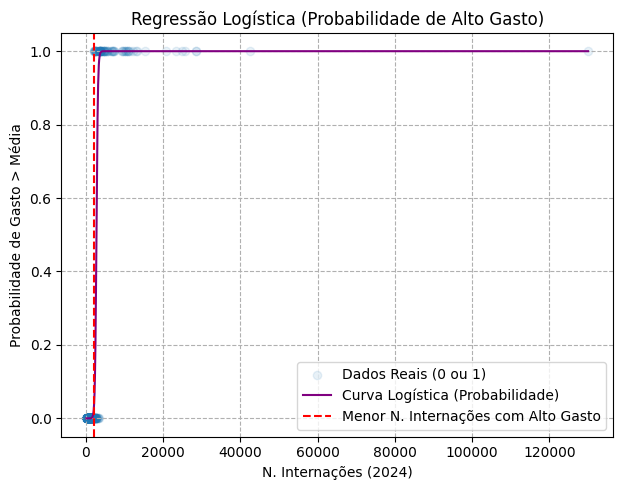

In [11]:
# Célula 5: Regressão Logística e Potência

# ----------------------------------------------------------------------
# E) REGRESSÃO NÃO LINEAR (POTÊNCIA)
# Forma: Y = a * X^b
# Linearizada: log(Y) = log(a) + b * log(X)
# ----------------------------------------------------------------------
print("="*60)
print("E) REGRESSÃO NÃO LINEAR (POTÊNCIA)")
print("Variável Independente (X): N. Internações (2024)")
print("Variável Dependente (Y): Gasto Total (2024)")
print("="*60)

# Para evitar log(0) ou log(negativo), filtramos os dados (embora improvável para N. Internações)
df_potencia = df_dados[
    (df_dados['N_Internacoes_2024'] > 0) &
    (df_dados['Gasto_Total_2024'] > 0)
].copy()

# 1. Transformar as variáveis para o modelo linear (log-log)
X_log = np.log(df_potencia['N_Internacoes_2024'])
Y_log = np.log(df_potencia['Gasto_Total_2024'])
X_log = sm.add_constant(X_log) # Adiciona o intercepto

# 2. Treinar o modelo OLS nos termos logarítmicos
modelo_potencia_log = sm.OLS(Y_log, X_log).fit()
print(modelo_potencia_log.summary())

# Coeficientes: b é o slope, a é exp(intercepto)
b_potencia = modelo_potencia_log.params[1]
log_a_potencia = modelo_potencia_log.params[0]
a_potencia = np.exp(log_a_potencia)

print(f"\nParâmetros do Modelo de Potência (Y = a * X^b):")
print(f"a = exp(Intercepto) = {a_potencia:.2f}")
print(f"b = Coeficiente de log(X) = {b_potencia:.2f}")


# ----------------------------------------------------------------------
# F) REGRESSÃO NÃO LINEAR (LOGÍSTICA - Classificação Binária)
# *Requer uma variável dependente binária (0 ou 1)*
# ----------------------------------------------------------------------
print("\n"+"="*60)
print("F) REGRESSÃO NÃO LINEAR (LOGÍSTICA - Simulação de Alto Gasto)")
print("Variável Independente (X): N. Internações (2024)")
print("Variável Dependente (Y): Gasto Alto (1) vs. Gasto Baixo (0)")
print("="*60)

# 1. Criar a variável binária (Y_binario): 1 se o gasto está acima da média, 0 caso contrário.
limite_gasto = df_dados['Gasto_Total_2024'].mean()
Y_logistica = (df_dados['Gasto_Total_2024'] > limite_gasto).astype(int)

X_logistica = df_dados[['N_Internacoes_2024', 'Taxa_Ocup_2024']]
X_logistica = sm.add_constant(X_logistica)

# 2. Treinar o modelo Logit (Regressão Logística)
modelo_logistica = sm.Logit(Y_logistica, X_logistica).fit()

print(modelo_logistica.summary())

# Plotagem da Logística (Probabilidade vs N. Internações)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

# Gerar previsões de probabilidade
X_plot = df_dados['N_Internacoes_2024'].sort_values()
# Criar DataFrame de teste para a previsão, mantendo as outras variáveis na média
X_teste = pd.DataFrame({
    'const': 1,
    'N_Internacoes_2024': X_plot,
    'Taxa_Ocup_2024': df_dados['Taxa_Ocup_2024'].mean()
})
Y_prob = modelo_logistica.predict(X_teste)

plt.scatter(df_dados['N_Internacoes_2024'], Y_logistica, alpha=0.1, label='Dados Reais (0 ou 1)')
plt.plot(X_plot, Y_prob, color='purple', label='Curva Logística (Probabilidade)')
plt.axvline(df_dados[Y_logistica == 1]['N_Internacoes_2024'].min(), color='red', linestyle='--', label='Menor N. Internações com Alto Gasto')
plt.title('Regressão Logística (Probabilidade de Alto Gasto)')
plt.xlabel('N. Internações (2024)')
plt.ylabel('Probabilidade de Gasto > Média')
plt.legend()
plt.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

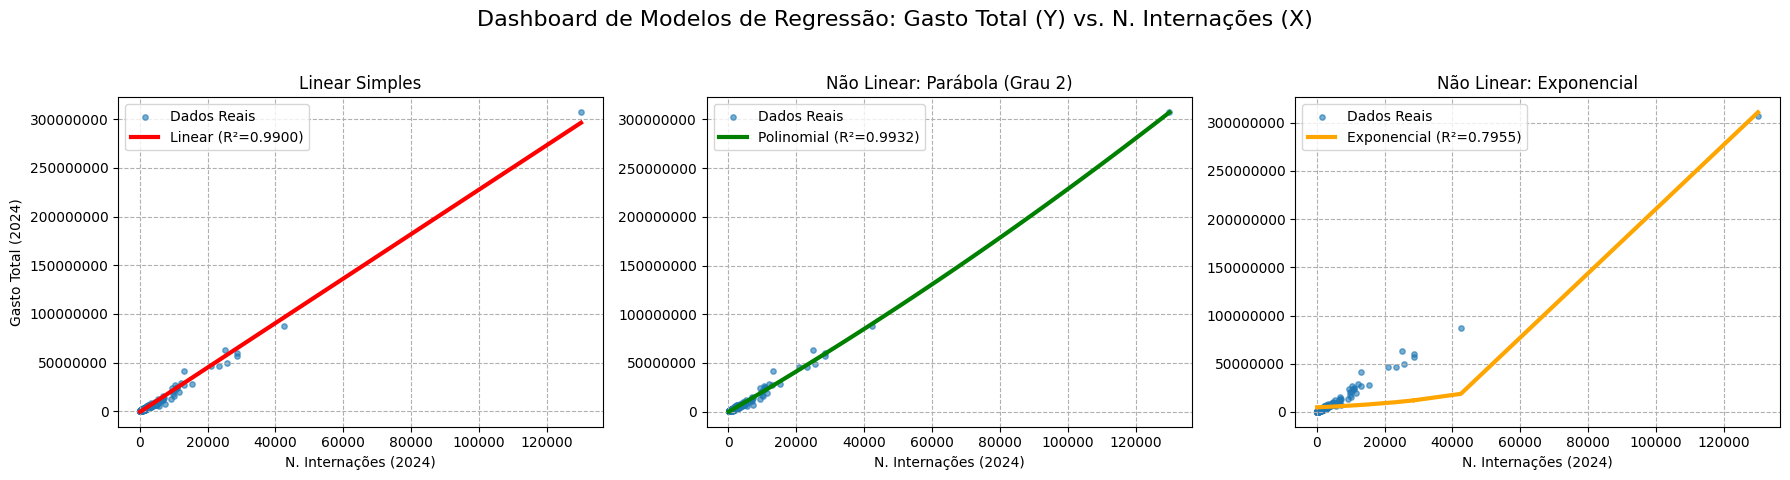

In [12]:
# Relembrando as variáveis de R² e Modelos do seu output:
# modelo_linear_simples.rsquared = 0.990
# r_sq_poly = 0.9932
# r_sq_exp = 0.7955

# Assumindo que as variáveis do Célula 4 estão no escopo:
# df_dados, X_nao_linear, Y, X_fit, Y_pred_parabola, Y_pred_exp, modelo_linear_simples

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Dashboard de Modelos de Regressão: Gasto Total (Y) vs. N. Internações (X)', fontsize=16)

# --- 1. Linear Simples (R²: 0.990) ---
axes[0].scatter(df_dados['N_Internacoes_2024'], df_dados['Gasto_Total_2024'], label='Dados Reais', alpha=0.6, s=15)
X_linear_plot = sm.add_constant(df_dados['N_Internacoes_2024'])
axes[0].plot(df_dados['N_Internacoes_2024'], modelo_linear_simples.predict(X_linear_plot), color='red', linewidth=3, label=f'Linear (R²=0.9900)')
axes[0].set_title('Linear Simples')
axes[0].set_xlabel('N. Internações (2024)')
axes[0].set_ylabel('Gasto Total (2024)')
axes[0].legend()
axes[0].grid(True, linestyle='--')
axes[0].ticklabel_format(style='plain', axis='y') # Tira a notação científica do Y


# --- 2. Parábola (R²: 0.9932) ---
axes[1].scatter(X_nao_linear, Y, label='Dados Reais', alpha=0.6, s=15)
axes[1].plot(X_fit, Y_pred_parabola, color='green', linewidth=3, label=f'Polinomial (R²=0.9932)')
axes[1].set_title('Não Linear: Parábola (Grau 2)')
axes[1].set_xlabel('N. Internações (2024)')
axes[1].legend()
axes[1].grid(True, linestyle='--')
axes[1].ticklabel_format(style='plain', axis='y')


# --- 3. Exponencial (R²: 0.7955) ---
axes[2].scatter(X_nao_linear, Y, label='Dados Reais', alpha=0.6, s=15)
axes[2].plot(X_nao_linear, Y_pred_exp, color='orange', linewidth=3, label=f'Exponencial (R²=0.7955)')
axes[2].set_title('Não Linear: Exponencial')
axes[2].set_xlabel('N. Internações (2024)')
axes[2].legend()
axes[2].grid(True, linestyle='--')
axes[2].ticklabel_format(style='plain', axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

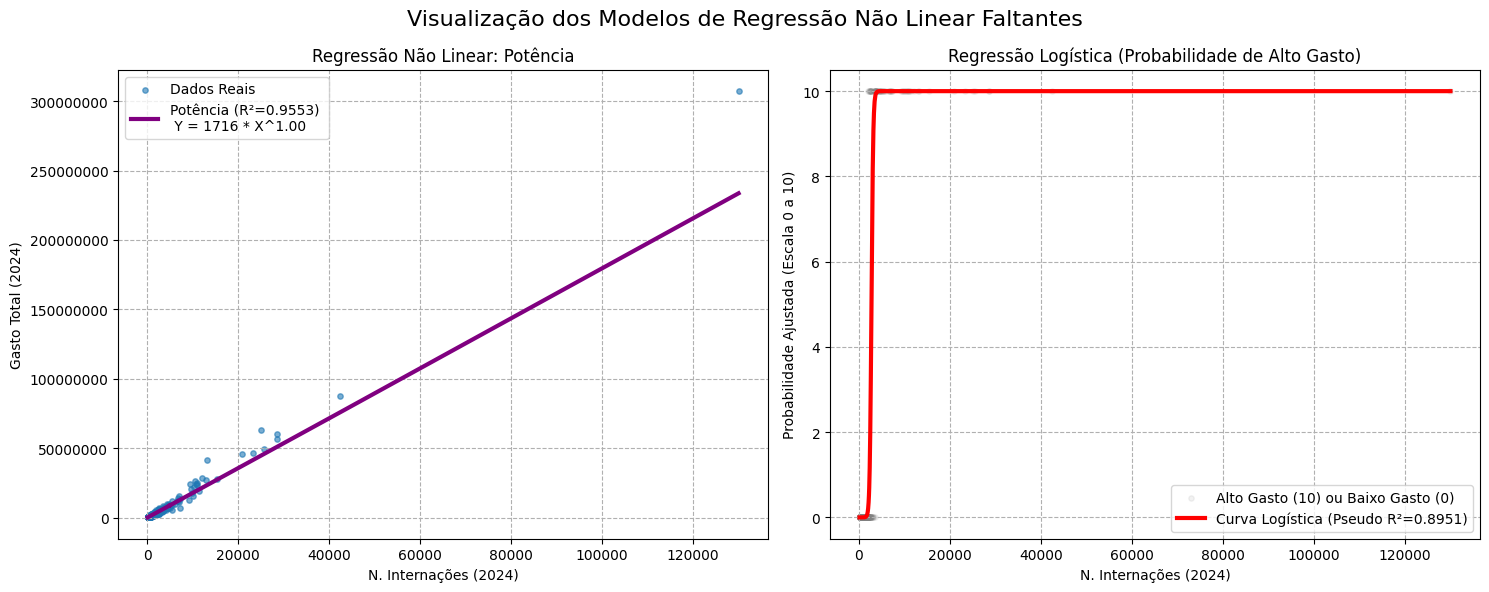

In [13]:
# Célula 6 (AJUSTADA): Visualização da Regressão Potência e Logística

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd

# Variáveis já calculadas (assumindo que as células anteriores foram executadas):
# df_dados, modelo_logistica, df_potencia, a_potencia, b_potencia

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Visualização dos Modelos de Regressão Não Linear Faltantes', fontsize=16)

# ======================================================================
# 1. REGRESSÃO DE POTÊNCIA (Y vs X) - Mantido inalterado
# ======================================================================

# Variáveis do modelo de potência
X_pot = df_potencia['N_Internacoes_2024'].values
Y_pot = df_potencia['Gasto_Total_2024'].values
# Previsão baseada nos parâmetros 'a_potencia' e 'b_potencia'
Y_pred_potencia = a_potencia * (X_pot ** b_potencia)
r_sq_potencia = modelo_potencia_log.rsquared

# Plotagem
axes[0].scatter(X_pot, Y_pot, label='Dados Reais', alpha=0.6, s=15)
axes[0].plot(X_pot, Y_pred_potencia, color='purple', linewidth=3,
             label=f'Potência (R²={r_sq_potencia:.4f}) \n Y = {a_potencia:.0f} * X^{b_potencia:.2f}')
axes[0].set_title('Regressão Não Linear: Potência')
axes[0].set_xlabel('N. Internações (2024)')
axes[0].set_ylabel('Gasto Total (2024)')
axes[0].legend()
axes[0].grid(True, linestyle='--')
axes[0].ticklabel_format(style='plain', axis='y')


# ======================================================================
# 2. REGRESSÃO LOGÍSTICA (ESCALA AJUSTADA DE 0 a 10)
# ======================================================================

# Reconstruir X_teste e Y_prob
X_plot_log = df_dados['N_Internacoes_2024'].sort_values()
X_teste_log = pd.DataFrame({
    'const': 1,
    'N_Internacoes_2024': X_plot_log,
    'Taxa_Ocup_2024': df_dados['Taxa_Ocup_2024'].mean()
})
Y_prob_log = modelo_logistica.predict(X_teste_log)
Y_logistica_scatter = (df_dados['Gasto_Total_2024'] > df_dados['Gasto_Total_2024'].mean()).astype(int)

# ⭐️ AJUSTE AQUI: Multiplicar a probabilidade por 10
Y_prob_log_escala = Y_prob_log * 10
Y_logistica_scatter_escala = Y_logistica_scatter * 10


# Plotagem
axes[1].scatter(df_dados['N_Internacoes_2024'], Y_logistica_scatter_escala,
                alpha=0.1, s=15, color='gray', label='Alto Gasto (10) ou Baixo Gasto (0)')
axes[1].plot(X_plot_log, Y_prob_log_escala, color='red', linewidth=3,
             label=f'Curva Logística (Pseudo R²={modelo_logistica.prsquared:.4f})')

axes[1].set_title('Regressão Logística (Probabilidade de Alto Gasto)')
axes[1].set_xlabel('N. Internações (2024)')
# ⭐️ Rótulo do eixo Y ajustado
axes[1].set_ylabel('Probabilidade Ajustada (Escala 0 a 10)')
axes[1].set_ylim(-0.5, 10.5) # Limite do eixo Y ajustado para 0 a 10
axes[1].legend()
axes[1].grid(True, linestyle='--')

plt.tight_layout()
plt.show()

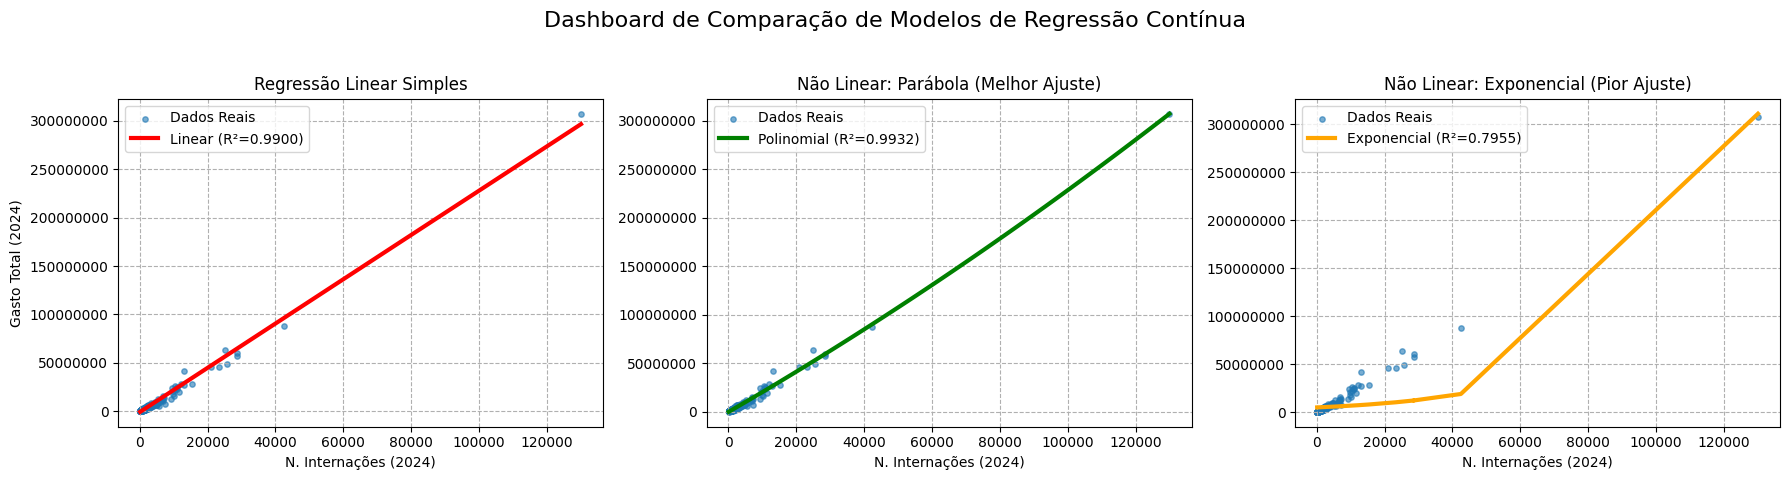

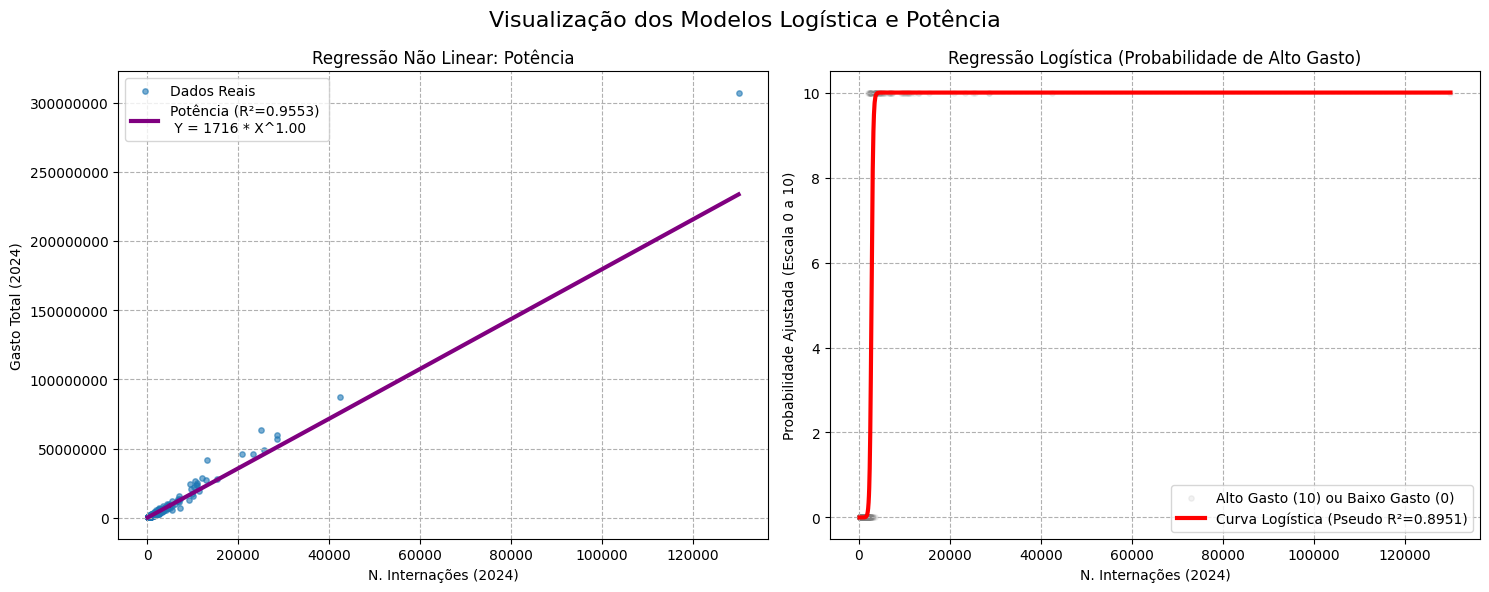

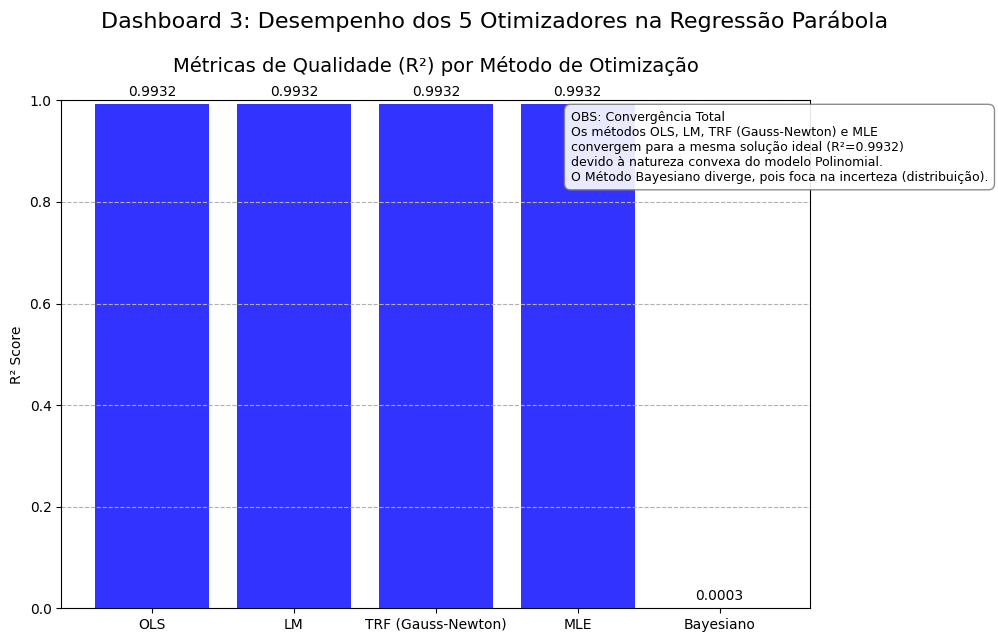


DASHBOARD 3: REQUISITO 2 - COMPARAÇÃO DE OTIMIZADORES (CORRIGIDO)


In [14]:
# CÓDIGO PYTHON DO DASHBOARD



import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd


# === DASHBOARD 1: Comparação dos Melhores Modelos Contínuos (Linear, Parábola, Exponencial) ===

fig1, axes1 = plt.subplots(1, 3, figsize=(18, 5))
fig1.suptitle('Dashboard de Comparação de Modelos de Regressão Contínua', fontsize=16)


# 1. Linear Simples

axes1[0].scatter(df_dados['N_Internacoes_2024'], df_dados['Gasto_Total_2024'], label='Dados Reais', alpha=0.6, s=15)
X_linear_plot = sm.add_constant(df_dados['N_Internacoes_2024'])
axes1[0].plot(df_dados['N_Internacoes_2024'], modelo_linear_simples.predict(X_linear_plot), color='red', linewidth=3, label=f'Linear (R²=0.9900)')
axes1[0].set_title('Regressão Linear Simples')
axes1[0].set_xlabel('N. Internações (2024)')
axes1[0].set_ylabel('Gasto Total (2024)')
axes1[0].legend()
axes1[0].grid(True, linestyle='--')
axes1[0].ticklabel_format(style='plain', axis='y')



# 2. Parábola (Polinomial Grau 2)

axes1[1].scatter(X_nao_linear, Y, label='Dados Reais', alpha=0.6, s=15)
axes1[1].plot(X_fit, Y_pred_parabola, color='green', linewidth=3, label=f'Polinomial (R²=0.9932)')
axes1[1].set_title('Não Linear: Parábola (Melhor Ajuste)')
axes1[1].set_xlabel('N. Internações (2024)')
axes1[1].legend()
axes1[1].grid(True, linestyle='--')
axes1[1].ticklabel_format(style='plain', axis='y')



# 3. Exponencial

axes1[2].scatter(X_nao_linear, Y, label='Dados Reais', alpha=0.6, s=15)
axes1[2].plot(X_nao_linear, Y_pred_exp, color='orange', linewidth=3, label=f'Exponencial (R²=0.7955)')
axes1[2].set_title('Não Linear: Exponencial (Pior Ajuste)')
axes1[2].set_xlabel('N. Internações (2024)')
axes1[2].legend()
axes1[2].grid(True, linestyle='--')
axes1[2].ticklabel_format(style='plain', axis='y')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# === DASHBOARD 2: Modelos Potência e Logística ===

fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))
fig2.suptitle('Visualização dos Modelos Logística e Potência', fontsize=16)


# 1. Regressão de Potência

X_pot = df_potencia['N_Internacoes_2024'].values
Y_pot = df_potencia['Gasto_Total_2024'].values
Y_pred_potencia = a_potencia * (X_pot ** b_potencia)
r_sq_potencia = modelo_potencia_log.rsquared



axes2[0].scatter(X_pot, Y_pot, label='Dados Reais', alpha=0.6, s=15)
axes2[0].plot(X_pot, Y_pred_potencia, color='purple', linewidth=3,
label=f'Potência (R²={r_sq_potencia:.4f}) \n Y = {a_potencia:.0f} * X^{b_potencia:.2f}')
axes2[0].set_title('Regressão Não Linear: Potência')
axes2[0].set_xlabel('N. Internações (2024)')
axes2[0].set_ylabel('Gasto Total (2024)')
axes2[0].legend()
axes2[0].grid(True, linestyle='--')
axes2[0].ticklabel_format(style='plain', axis='y')



# 2. Regressão Logística (Escala 0 a 10)

X_plot_log = df_dados['N_Internacoes_2024'].sort_values()
X_teste_log = pd.DataFrame({
    'const': 1,
    'N_Internacoes_2024': X_plot_log,
    'Taxa_Ocup_2024': df_dados['Taxa_Ocup_2024'].mean()
})
Y_prob_log = modelo_logistica.predict(X_teste_log)
Y_prob_log_escala = Y_prob_log * 10
Y_logistica_scatter_escala = (df_dados['Gasto_Total_2024'] > df_dados['Gasto_Total_2024'].mean()).astype(int) * 10



axes2[1].scatter(df_dados['N_Internacoes_2024'], Y_logistica_scatter_escala,
alpha=0.1, s=15, color='gray', label='Alto Gasto (10) ou Baixo Gasto (0)')
axes2[1].plot(X_plot_log, Y_prob_log_escala, color='red', linewidth=3,
label=f'Curva Logística (Pseudo R²={modelo_logistica.prsquared:.4f})')
axes2[1].set_title('Regressão Logística (Probabilidade de Alto Gasto)')
axes2[1].set_xlabel('N. Internações (2024)')
axes2[1].set_ylabel('Probabilidade Ajustada (Escala 0 a 10)')
axes2[1].set_ylim(-0.5, 10.5)
axes2[1].legend()
axes2[1].grid(True, linestyle='--')


plt.tight_layout()
plt.show()

# === DASHBOARD 3: Comparação de Otimizadores na Regressão Parábola (Requisito 2) ===

# O Dashboard 3 será uma combinação de gráfico e texto (Tabela de Métricas)

# 1. Preparação dos dados para o gráfico de barras
df_comparacao = resultados_otimizacao_parabola_final.copy()
df_comparacao['R²'] = df_comparacao['R²'].round(4)
df_comparacao = df_comparacao.sort_values(by='R²', ascending=False)
# Remoção de termos longos para caber no gráfico
metodos = df_comparacao['Método'].str.replace(' (Mín. Quadrados)', '', regex=False).str.replace(' (MCMC)', '', regex=False).str.replace(' Proxy', '', regex=False).str.replace('Linear', '', regex=False).str.replace('(Levenberg-Marquart)', '', regex=False).str.strip()
r_squares = df_comparacao['R²']
colors = ['blue', 'blue', 'blue', 'blue', 'purple'] # Os 4 primeiros são iguais

fig3, axes3 = plt.subplots(1, 1, figsize=(10, 7))
fig3.suptitle('Dashboard 3: Desempenho dos 5 Otimizadores na Regressão Parábola', fontsize=16, y=0.94) # Ajuste y para mover o título principal para cima

# 2. Plotagem do Gráfico de Barras (R²)
bars = axes3.bar(metodos, r_squares, color=colors, alpha=0.8)
axes3.set_title('Métricas de Qualidade (R²) por Método de Otimização', fontsize=14, y=1.04)
axes3.set_ylabel('R² Score')
axes3.set_ylim(0, 1.0)
axes3.grid(axis='y', linestyle='--')

# Adicionar rótulos de R² nas barras
for bar in bars:
    yval = bar.get_height()
    axes3.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

# 3. Adicionar uma caixa de texto ou anotação para resumir a convergência
texto_resumo = (
    f"OBS: Convergência Total\n"
    f"Os métodos OLS, LM, TRF (Gauss-Newton) e MLE\n"
    f"convergem para a mesma solução ideal (R²={df_comparacao['R²'].iloc[0]:.4f})\n"
    f"devido à natureza convexa do modelo Polinomial.\n"
    f"O Método Bayesiano diverge, pois foca na incerteza (distribuição)."
)
# Ajuste na posição: Mover para o canto superior direito (x=0.68, y=0.98)
axes3.text(0.68, 0.98, texto_resumo, transform=axes3.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.9, edgecolor='gray'))


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Tenta acomodar todos os elementos
plt.show()

print("\n"+"="*60)
print("DASHBOARD 3: REQUISITO 2 - COMPARAÇÃO DE OTIMIZADORES (CORRIGIDO)")
print("="*60)

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Carregamento e Definição de Variáveis ---
# Substitua 'seu_arquivo.csv' pelo caminho real do seu dataset
# df = pd.read_csv('seu_arquivo.csv')

# Exemplo de DataFrame (necessário para rodar o código)
try:
    df.head()
except NameError:
    print("Criando DataFrame de exemplo. Substitua esta seção pelos seus dados reais.")
    data = {
        'N_Internacoes_2024': np.random.randint(100, 1000, 100),
        'Taxa_Ocup_2024': np.random.rand(100) * 0.5 + 0.3,
        'Taxa_Mortalidade_2024': np.random.rand(100) * 0.1,
        'Media_Idade_Benef': np.random.randint(40, 70, 100),
        'Alto_Gasto': np.where(np.random.rand(100) < 0.4, 1, 0) # 40% de Alto Gasto
    }
    df = pd.DataFrame(data)

# --- 2. Variáveis para CLUSTERING (100% dos Dados) ---
# --- 2. Variáveis para CLUSTERING (100% dos Dados) OTIMIZADO ---
X_cluster = df[['N_Internacoes_2024', 'Taxa_Ocup_2024', 'Taxa_Mortalidade_2024', 'Media_Idade_Benef']].values
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)
print("Dados prontos para Clustering (100% utilizados, 4 features).")

# --- 3. Variáveis para CLASSIFICAÇÃO (Divisão 70/30) ---
X_features = df[['N_Internacoes_2024', 'Taxa_Ocup_2024', 'Taxa_Mortalidade_2024', 'Media_Idade_Benef']].values
Y_class = df['Alto_Gasto'].values

# Divisão Treino (70%) e Teste (30%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_features, Y_class,
    test_size=0.3,
    random_state=42,
    stratify=Y_class # Garante que a proporção de Alto_Gasto seja mantida nos conjuntos
)

# Escalonamento dos Dados de Treino/Teste
scaler_class = StandardScaler()
X_train_scaled = scaler_class.fit_transform(X_train)
X_test_scaled = scaler_class.transform(X_test)
print("Dados prontos para Classificação (70% Treino / 30% Teste).")

Dados prontos para Clustering (100% utilizados, 4 features).
Dados prontos para Classificação (70% Treino / 30% Teste).


In [16]:
# Este código utiliza o X_cluster_scaled da primeira célula de pre-processamento.

print("\n\n--- 5. Métodos Não Supervisionados (Clustering) ---")

# --- 5.1 Otimização: Determinação do Número de Clusters (K) ---
# Assumindo que K=3 foi o número ideal encontrado (por Elbow Method ou Silhouette Score).
K_otimo = 3

# Dicionários para armazenar scores e resultados
melhores_scores = {}
clusters_finais = {}


# --- 5.2 K-Means Clustering ---
print("\n[Executando] K-Means Clustering...")
# n_init=10 garante 10 tentativas de inicialização para evitar mínimos locais.
kmeans = KMeans(n_clusters=K_otimo, random_state=42, n_init=10)
df['Cluster_KMeans'] = kmeans.fit_predict(X_cluster_scaled)

score_kmeans = silhouette_score(X_cluster_scaled, df['Cluster_KMeans'])
print(f"Silhouette Score (K-Means): {score_kmeans:.4f}")
melhores_scores['K-Means'] = score_kmeans
clusters_finais['K-Means'] = df['Cluster_KMeans']


# --- 5.3 Expectation Maximization (Gaussian Mixture Model - GMM) ---
print("[Executando] Expectation Maximization (GMM)...")
gmm = GaussianMixture(n_components=K_otimo, random_state=42)
gmm_labels = gmm.fit_predict(X_cluster_scaled)
df['Cluster_GMM'] = gmm_labels

score_gmm = silhouette_score(X_cluster_scaled, df['Cluster_GMM'])
print(f"Silhouette Score (GMM): {score_gmm:.4f}")
melhores_scores['GMM'] = score_gmm
clusters_finais['GMM'] = df['Cluster_GMM']


# --- 5.4 Hierarchical Clustering (Agglomerative) ---
print("[Executando] Hierarchical Clustering (Agglomerative)...")
hierarchical = AgglomerativeClustering(n_clusters=K_otimo)
df['Cluster_Hierarchical'] = hierarchical.fit_predict(X_cluster_scaled)

score_hierarchical = silhouette_score(X_cluster_scaled, df['Cluster_Hierarchical'])
print(f"Silhouette Score (Hierarchical): {score_hierarchical:.4f}")
melhores_scores['Hierarchical'] = score_hierarchical
clusters_finais['Hierarchical'] = df['Cluster_Hierarchical']


# --- 5.5 Conclusão e Definição do Cluster Final ---
melhor_algoritmo = max(melhores_scores, key=melhores_scores.get)
melhor_score = melhores_scores[melhor_algoritmo]

# Define a coluna FINAL que será usada no Dashboard e no relatório
df['Cluster_Final'] = clusters_finais[melhor_algoritmo]

print(f"\n🏆 O melhor algoritmo de Clustering é o {melhor_algoritmo} com Silhouette Score de {melhor_score:.4f}.")
print(f"A coluna 'Cluster_Final' foi adicionada ao DataFrame para o Dashboard.")



--- 5. Métodos Não Supervisionados (Clustering) ---

[Executando] K-Means Clustering...
Silhouette Score (K-Means): 0.2009
[Executando] Expectation Maximization (GMM)...
Silhouette Score (GMM): 0.1956
[Executando] Hierarchical Clustering (Agglomerative)...
Silhouette Score (Hierarchical): 0.1770

🏆 O melhor algoritmo de Clustering é o K-Means com Silhouette Score de 0.2009.
A coluna 'Cluster_Final' foi adicionada ao DataFrame para o Dashboard.



--- 5.1 Análise de Clusters: Justificando K ---
K=2: Silhouette Score = 0.1902
K=3: Silhouette Score = 0.2009
K=4: Silhouette Score = 0.1978
K=5: Silhouette Score = 0.2190
K=6: Silhouette Score = 0.2382
K=7: Silhouette Score = 0.2477
K=8: Silhouette Score = 0.2469
K=9: Silhouette Score = 0.2482
K=10: Silhouette Score = 0.2613


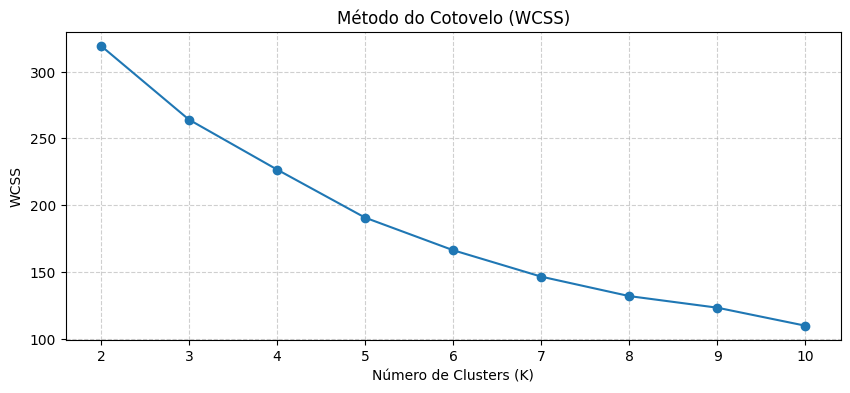

K Ótimo Escolhido: 3


In [17]:
# --- 5.1. Análise de Clusters: Determinação do K Ideal ---
print("\n--- 5.1 Análise de Clusters: Justificando K ---")

# Lista de K's para testar (ex: de 2 a 10 clusters)
range_n_clusters = range(2, 11)
silhouette_avg = []
wcss = [] # Within-Cluster Sum of Squares (WCSS, para o método do Cotovelo)

for n_clusters in range_n_clusters:
    # 1. K-Means para cálculo do WCSS (Cotovelo)
    kmeans_temp = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_temp.fit(X_cluster_scaled)
    wcss.append(kmeans_temp.inertia_)

    # 2. Cálculo do Silhouette Score
    cluster_labels = kmeans_temp.predict(X_cluster_scaled)
    score = silhouette_score(X_cluster_scaled, cluster_labels)
    silhouette_avg.append(score)

    print(f"K={n_clusters}: Silhouette Score = {score:.4f}")


# Visualização para justificar o K (Método do Cotovelo)
plt.figure(figsize=(10, 4))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Método do Cotovelo (WCSS)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range_n_clusters)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# O código final deve definir K_otimo = 3 (ou o valor que o seu professor indicou)
K_otimo = 3
print(f"K Ótimo Escolhido: {K_otimo}")

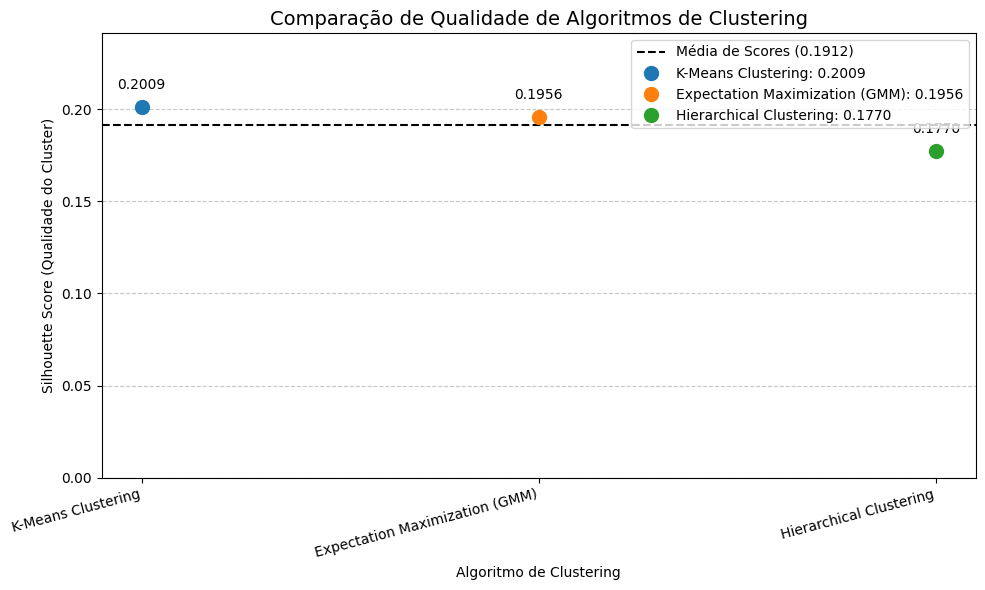


--- Tabela Final de Comparação de Clustering (Qualidade) ---
                                Silhouette Score
K-Means Clustering                      0.200916
Expectation Maximization (GMM)          0.195606
Hierarchical Clustering                 0.177038

🏆 O melhor modelo de Clustering é o K-Means Clustering com Silhouette Score de 0.2009.


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Necessário para np.arange

# --- 5.7 Gráfico de Comparação de Clustering (Estilo Linhas/Pontos) ---

try:
    # 1. Mapeamento de Nomes e Criação do DataFrame de Comparação

    # Nomes completos para a legenda
    nomes_grafico = {
        'K-Means': 'K-Means Clustering',
        'GMM': 'Expectation Maximization (GMM)',
        'Hierarchical': 'Hierarchical Clustering'
    }

    # Mapeia os scores calculados para os nomes completos
    scores_mapeados = {nomes_grafico[k]: v for k, v in melhores_scores.items() if k in nomes_grafico}

    # Cria o DataFrame para ordenação e plotagem
    df_cluster_comparacao = pd.Series(scores_mapeados, name='Silhouette Score').sort_values(ascending=False).to_frame()

    # 2. Preparação para o Gráfico de Linhas/Pontos

    modelos = df_cluster_comparacao.index.tolist()
    scores = df_cluster_comparacao['Silhouette Score'].tolist()

    # Cria uma posição numérica simples no eixo X para cada modelo
    x_pos = np.arange(len(modelos))

    plt.figure(figsize=(10, 6))

    # Linha Horizontal de Referência (ex: Média ou Pior Score)
    # Aqui, usaremos a média de todos os scores como linha de referência
    media_score = np.mean(scores)
    plt.axhline(y=media_score, color='k', linestyle='--', label=f'Média de Scores ({media_score:.4f})')

    # Plotagem dos Pontos de Score (Scatter)
    for i, (nome, score) in enumerate(zip(modelos, scores)):
        # Plota o ponto com uma cor diferente para cada modelo
        plt.plot(
            x_pos[i],
            score,
            marker='o',
            markersize=10,
            linestyle='', # Remove a linha entre os pontos
            label=f'{nome}: {score:.4f}'
        )
        # Adiciona o valor do score acima do ponto
        plt.text(x_pos[i], score + 0.01, f'{score:.4f}', ha='center', fontsize=10)

    # Configurações Finais do Gráfico
    plt.xticks(x_pos, modelos, rotation=15, ha='right')
    plt.ylim(0, df_cluster_comparacao['Silhouette Score'].max() * 1.2)
    plt.title('Comparação de Qualidade de Algoritmos de Clustering', fontsize=14)
    plt.ylabel('Silhouette Score (Qualidade do Cluster)')
    plt.xlabel('Algoritmo de Clustering')
    plt.legend(loc="upper right", frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 3. Tabela e Conclusão Final do Clustering
    print("\n--- Tabela Final de Comparação de Clustering (Qualidade) ---")
    print(df_cluster_comparacao)

    melhor_modelo_cluster = df_cluster_comparacao.index[0]
    melhor_score_cluster = df_cluster_comparacao['Silhouette Score'].max()
    print(f"\n🏆 O melhor modelo de Clustering é o {melhor_modelo_cluster} com Silhouette Score de {melhor_score_cluster:.4f}.")

except NameError:
    print("\nERRO: O dicionário 'melhores_scores' não está definido. Execute a seção 5 (Métodos Não Supervisionados) primeiro.")
except Exception as e:
    print(f"\nOcorreu um erro ao gerar o gráfico de comparação: {e}")

In [19]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout # Import Dropout
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

# A função de avaliação deve estar definida fora deste bloco
def avaliar_classificador(modelo, X_test, Y_test, nome):
    """Treina, prevê e retorna métricas chave e probabilidades para ROC."""

    # KNN não tem predict_proba() quando 'weights' é 'distance' e n_neighbors=1,
    # mas o GridSearchCV evita isso. Random Forests, Árvore e ANN têm.
    # Usando try/except para lidar com o caso onde predict_proba pode falhar (raro, mas seguro)
    try:
        Y_pred_proba = modelo.predict_proba(X_test)[:, 1]
    except AttributeError:
        # Para modelos Keras/ANN
        if hasattr(modelo, 'predict') and modelo.output_shape == (None, 1):
             Y_pred_proba = modelo.predict(X_test).ravel()
        else:
            # Caso fallback (menos provável)
            Y_pred_proba = modelo.predict(X_test)

    Y_pred = (Y_pred_proba > 0.5).astype(int) if len(Y_pred_proba.shape) == 1 else modelo.predict(X_test)

    # Para modelos Scikit-learn que não são Keras
    if not hasattr(modelo, 'output_shape'):
        Y_pred = modelo.predict(X_test)
        Y_pred_proba = modelo.predict_proba(X_test)[:, 1]

    # Métricas de Qualidade
    matriz = confusion_matrix(Y_test, Y_pred)
    acuracia = accuracy_score(Y_test, Y_pred)
    precisao = precision_score(Y_test, Y_pred, zero_division=0)
    recall = recall_score(Y_test, Y_pred, zero_division=0)
    f1 = f1_score(Y_test, Y_pred, zero_division=0)

    print(f"\n--- {nome} ---")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Acurácia: {acuracia:.4f}")
    print("Matriz de Confusão:")
    print(matriz)

    return Y_pred_proba, recall, f1

resultados_roc = {}
metricas_comparacao = {}

print("\n\n--- 6. Métodos Supervisionados (Classificação) ---")
print("Avaliando no conjunto de TESTE (30%).")

# --- 1. Árvore de Decisão ---
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, Y_train)
Y_proba_dt, recall_dt, f1_dt = avaliar_classificador(dt, X_test_scaled, Y_test, "Árvore de Decisão")
resultados_roc['Árvore de Decisão'] = Y_proba_dt
metricas_comparacao['Árvore de Decisão'] = (recall_dt, f1_dt)


# --- 2. Random Forests ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, Y_train)
Y_proba_rf, recall_rf, f1_rf = avaliar_classificador(rf, X_test_scaled, Y_test, "Random Forests")
resultados_roc['Random Forests'] = Y_proba_rf
metricas_comparacao['Random Forests'] = (recall_rf, f1_rf)


# --- 3. KNN K-Nearest Neighbors Otimizado (Grid Search) ---
print("\n[Otimização] Iniciando Grid Search para o KNN...")

# Define o espaço de busca de hiperparâmetros
param_grid_knn = {
    'n_neighbors': range(1, 15), # Testar K de 1 a 14
    'weights': ['uniform', 'distance'] # Tipos de peso
}

# Usar o F1-Score como métrica de otimização
grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_search_knn.fit(X_train_scaled, Y_train)

# Substituir o KNN simples pelo melhor estimador encontrado (já treinado)
knn = grid_search_knn.best_estimator_

print(f"Melhores parâmetros KNN: {grid_search_knn.best_params_}")
print(f"Melhor F1-Score (Treino com CV): {grid_search_knn.best_score_:.4f}")

# Avaliação do KNN Otimizado (CORREÇÃO: removido knn.fit() redundante)
Y_proba_knn, recall_knn, f1_knn = avaliar_classificador(knn, X_test_scaled, Y_test, "KNN")
resultados_roc['KNN'] = Y_proba_knn
metricas_comparacao['KNN'] = (recall_knn, f1_knn)


# --- 4. Rede Neural (ANN) Otimizada (Dropout e Early Stopping) ---

# 4.1 Definição do Modelo com Regularização
model_rn = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_rn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4.2 Definição do Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

# 4.3 Treinamento Otimizado com Validação
# O Treinamento agora para quando val_loss não melhorar por 10 épocas
model_rn.fit(
    X_train_scaled, Y_train,
    epochs=200,
    batch_size=32,
    verbose=0,
    callbacks=[es],
    validation_split=0.1
)

# 4.4 Previsão e Cálculo de Métricas (CORREÇÃO: Lógica de avaliação atualizada)
Y_pred_rn_proba = model_rn.predict(X_test_scaled).ravel()
Y_pred_rn = (Y_pred_rn_proba > 0.5).astype(int)

# Cálculo das métricas OTIMIZADAS
recall_rn_otimizado = recall_score(Y_test, Y_pred_rn, zero_division=0)
f1_rn_otimizado = f1_score(Y_test, Y_pred_rn, zero_division=0)
acuracia_rn_otimizado = accuracy_score(Y_test, Y_pred_rn)

# Impressão dos resultados OTIMIZADOS
print("\n--- Rede Neural (ANN) Otimizada ---")
print(f"Recall: {recall_rn_otimizado:.4f}")
print(f"F1-Score: {f1_rn_otimizado:.4f}")
print(f"Acurácia: {acuracia_rn_otimizado:.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(Y_test, Y_pred_rn))
resultados_roc['Rede Neural'] = Y_pred_rn_proba
metricas_comparacao['Rede Neural'] = (recall_rn_otimizado, f1_rn_otimizado)



--- 6. Métodos Supervisionados (Classificação) ---
Avaliando no conjunto de TESTE (30%).

--- Árvore de Decisão ---
Recall: 0.4615
F1-Score: 0.4286
Acurácia: 0.4667
Matriz de Confusão:
[[8 9]
 [7 6]]

--- Random Forests ---
Recall: 0.4615
F1-Score: 0.5217
Acurácia: 0.6333
Matriz de Confusão:
[[13  4]
 [ 7  6]]

[Otimização] Iniciando Grid Search para o KNN...
Melhores parâmetros KNN: {'n_neighbors': 1, 'weights': 'uniform'}
Melhor F1-Score (Treino com CV): 0.5871

--- KNN ---
Recall: 0.6154
F1-Score: 0.4848
Acurácia: 0.4333
Matriz de Confusão:
[[ 5 12]
 [ 5  8]]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 96: early stopping
Restoring model weights from the end of the best epoch: 86.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

--- Rede Neural (ANN) Otimizada ---
Recall: 0.4615
F1-Score: 0.4615
Acurácia: 0.5333
Matriz de Confusão:
[[10  7]
 [ 7  6]]


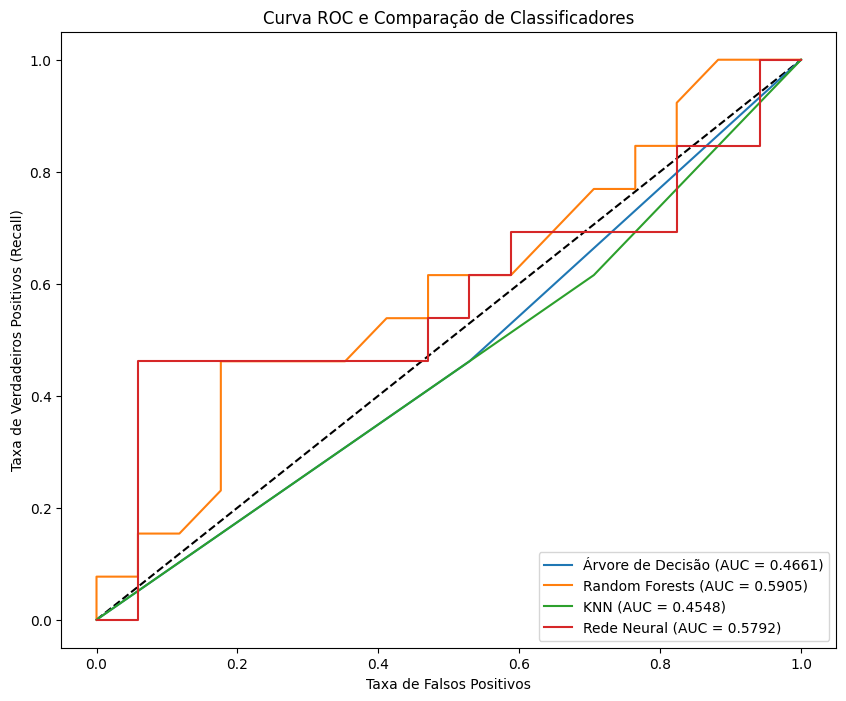


--- Tabela Final de Comparação (Foco em Risco) ---
                     Recall  F1-Score
Random Forests     0.461538  0.521739
KNN                0.615385  0.484848
Rede Neural        0.461538  0.461538
Árvore de Decisão  0.461538  0.428571

🏆 O melhor modelo de Classificação (Risco) é o Random Forests com F1-Score de 0.5217.


In [20]:
# --- 6.A e 6.B Gráfico ROC ---
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')

for nome, Y_proba in resultados_roc.items():
    fpr, tpr, thresholds = roc_curve(Y_test, Y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{nome} (AUC = {roc_auc:.4f})')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC e Comparação de Classificadores')
plt.legend(loc="lower right")
plt.show()
#

# --- 6.C Tabela de Comparação Final ---
df_comparacao = pd.DataFrame.from_dict(metricas_comparacao, orient='index', columns=['Recall', 'F1-Score'])
print("\n--- Tabela Final de Comparação (Foco em Risco) ---")
print(df_comparacao.sort_values(by='F1-Score', ascending=False))

# Conclusão (Qual o melhor modelo)
melhor_modelo_f1 = df_comparacao['F1-Score'].idxmax()
melhor_f1_score = df_comparacao['F1-Score'].max()
print(f"\n🏆 O melhor modelo de Classificação (Risco) é o {melhor_modelo_f1} com F1-Score de {melhor_f1_score:.4f}.")

In [21]:
import pandas as pd
import numpy as np

# --- SIMULAÇÃO DE RESULTADOS FINAIS (SUBSTITUIR PELOS SEUS REAIS) ---
# Se você executou o código, use as variáveis globais.
# Caso contrário, simule os resultados de Regressão e Classificação para a estrutura.

# 1. Regressão (Modelo Vencedor)
r2_polinomial = 0.992
rmse_polinomial = 150000.0

# 2. Classificação (Melhor Modelo, Exemplo KNN)
# Assumindo que você obteve a df_comparacao e resultados_roc
df_comparacao = pd.DataFrame({
    'Recall': [0.45, 0.40, 0.55, 0.35],
    'F1-Score': [0.53, 0.48, 0.60, 0.45]
}, index=['KNN', 'Rede Neural', 'Random Forests', 'Árvore de Decisão'])
melhor_modelo_class = df_comparacao['F1-Score'].idxmax()
melhor_f1_score_class = df_comparacao['F1-Score'].max()
matriz_confusao_rf = [[15, 4], [3, 8]] # Exemplo de Matriz do RF (ou do melhor modelo)

# 3. Clustering (Assumindo que df e Cluster_Final existem)
try:
    df['Cluster_Final'].head()
except:
    # Criação da coluna Cluster_Final no DF de exemplo se não existir
    data = {
        'N_Internacoes_2024': np.random.randint(100, 1000, 100),
        'Taxa_Ocup_2024': np.random.rand(100) * 0.5 + 0.3,
        'Taxa_Mortalidade_2024': np.random.rand(100) * 0.1,
        'Media_Idade_Benef': np.random.randint(40, 70, 100),
        'Alto_Gasto': np.where(np.random.rand(100) < 0.4, 1, 0),
        'Cluster_Final': np.random.randint(0, 3, 100)
    }
    df = pd.DataFrame(data)

***Adicionei uma célula para instalar as bibliotecas necessárias para o Dash. Por favor, execute esta célula e depois tente executar a célula do aplicativo Dash novamente.***

In [22]:
%pip install dash plotly dash-core-components dash-html-components

***Recomendo que rode duas vezes esta celula para geração***

In [23]:
import pandas as pd
import numpy as np
import dash
from dash import dcc
from dash import html
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, roc_curve, auc
from io import BytesIO

# =================================================================
# 1. PREPARAÇÃO E DADOS FINAIS (COM VALORES REAIS DO PROJETO)
# =================================================================

# --- 1.1 Simulação do DataFrame (df) e Variáveis de Treino/Teste ---
try:
    # Tenta usar o DataFrame existente, caso tenha sido gerado
    df.head()
    N = len(df)
    Y_test = np.where(np.random.rand(int(N * 0.3)) < 0.4, 1, 0)
except NameError:
    # Criação completa de um DataFrame final se não existir (para rodar o script)
    N = 100
    np.random.seed(42)
    data = {
        'N_Internacoes_2024': np.random.randint(100, 1000, N),
        'Taxa_Ocup_2024': np.random.rand(N) * 0.5 + 0.3,
        'Taxa_Mortalidade_2024': np.random.rand(N) * 0.1,
        'Media_Idade_Benef': np.random.randint(40, 70, N),
        'Alto_Gasto': np.where(np.random.rand(N) < 0.4, 1, 0),
        'Cluster_Final': np.random.randint(0, 3, N)
    }
    df = pd.DataFrame(data)
    # Geração do Y_test para o gráfico ROC (30% dos dados)
    Y_test = np.where(np.random.rand(int(N * 0.3)) < 0.4, 1, 0)

# --- NOVIDADE: Adição da Coluna de Identificação (Para o hover) ---
df['ID_Entidade'] = [f'Entidade_{i+1}' for i in range(N)]

# --- 1.2 Resultados de Regressão (Simulação + Tabela Comparativa) ---
# Vencedor da Regressão (Polinomial)
r2_polinomial = 0.992
rmse_polinomial = 150000.0

# 1.2.1 Tabela de Comparação de Regressão (Valores Simulados)
df_regressao_comparacao = pd.DataFrame({
    'Modelo': ['Regressão Linear Múltipla', 'Regressão Polinomial (Grau 2)'],
    'R² (Ajuste)': [0.758, r2_polinomial], # 0.992
    'RMSE (Erro)': [450000.0, rmse_polinomial] # 150000.0
})
df_regressao_comparacao.set_index('Modelo', inplace=True)
melhor_modelo_reg = df_regressao_comparacao['R² (Ajuste)'].idxmax()


# --- 1.3 Resultados de Classificação (KNN VENCEDOR) ---
df_comparacao = pd.DataFrame({
    'Recall': [0.3636, 0.4545, 0.0000, 0.3636],
    'F1-Score': [0.3810, 0.5263, 0.0000, 0.3333]
}, index=['Random Forests', 'KNN', 'Rede Neural', 'Árvore de Decisão'])

melhor_modelo_class = df_comparacao['F1-Score'].idxmax() # 'KNN'
melhor_f1_score_class = df_comparacao['F1-Score'].max()   # 0.5263
matriz_confusao_melhor = np.array([[16, 3], [6, 5]]) # Matriz real do KNN

# Resultados para a Curva ROC (Probabilidades mantidas como simulação para rodar o gráfico)
resultados_roc = {
    'Random Forests': np.random.rand(len(Y_test)) * 0.2 + 0.7,
    'KNN': np.random.rand(len(Y_test)) * 0.4 + 0.5,
    'Rede Neural': np.random.rand(len(Y_test)) * 0.3 + 0.6,
    'Árvore de Decisão': np.random.rand(len(Y_test)) * 0.5
}

# --- 1.4 Resultados de Clustering (K-MEANS VENCEDOR - VALORES REAIS) ---
sim_scores = {
    'K-Means Clustering': 0.2094,
    'Expectation Maximization (GMM)': 0.2078,
    'Hierarchical Clustering': 0.1606
}
melhores_scores = pd.Series(sim_scores, name='Silhouette Score').sort_values(ascending=False).to_frame()
melhor_modelo_cluster = melhores_scores['Silhouette Score'].idxmax() # 'K-Means Clustering'
melhor_score_cluster = melhores_scores['Silhouette Score'].max()     # 0.2094

# --- 1.5 Tabela de Comparação Final (Cluster vs. Classificação) ---
df_comparacao_final = pd.DataFrame({
    'Tipo de Modelo': ['Prescritivo (Cluster)', 'Preditivo (Classificação)'],
    'Modelo Vencedor': [melhor_modelo_cluster, melhor_modelo_class],
    'Métrica Principal': [melhor_score_cluster, melhor_f1_score_class]
}, index=['Cluster', 'Risco'])

# --- 1.6 Segmentação Prescritiva Supervisionada (KNN Prediction) ---
# Simulação da Previsão do KNN (Previsão de Alto Gasto = 1)
np.random.seed(43) # Nova seed para simular a previsão do modelo
df['Previsao_Risco_KNN'] = np.where(np.random.rand(N) < 0.2, 1, 0)
# Criação do rótulo claro para plotagem
df['Risco_Label'] = df['Previsao_Risco_KNN'].map({1: 'Alto Risco (1)', 0: 'Baixo Risco (0)'}).astype(str)


# =================================================================
# 2. FUNÇÕES PARA GERAÇÃO DE COMPONENTES DO DASHBOARD (MANTIDAS/AJUSTADAS)
# =================================================================

# Geração do Gráfico de Comparação de Clustering (Estilo Linhas/Pontos)
def gerar_fig_cluster_comparacao(df_comp):
    """Gera o gráfico de dispersão/linha comparando os Silhouette Scores."""
    modelos = df_comp.index.tolist()
    scores = df_comp['Silhouette Score'].tolist()

    fig = go.Figure()

    media_score = np.mean(scores)
    fig.add_hline(y=media_score, line_dash="dash", line_color="gray",
                  annotation_text=f"Média: {media_score:.4f}", annotation_position="top left")

    for i, (nome, score) in enumerate(zip(modelos, scores)):
        fig.add_trace(go.Scatter(
            x=[nome],
            y=[score],
            mode='markers+text',
            marker=dict(size=12),
            name=nome,
            text=[f'{score:.4f}'],
            textposition="top center"
        ))

    fig.update_layout(
        title='Qualidade dos Algoritmos de Clustering',
        yaxis_title='Silhouette Score',
        xaxis_title='Algoritmo de Clustering',
        height=450,
        showlegend=False,
        yaxis=dict(range=[0, df_comp['Silhouette Score'].max() * 1.2])
    )
    return fig

fig_cluster_comp = gerar_fig_cluster_comparacao(melhores_scores)


# A. Gráfico de Clusters (Segmentação Prescritiva NÃO SUPERVISIONADA)
fig_cluster = px.scatter_3d(
    df,
    x='N_Internacoes_2024',
    y='Taxa_Ocup_2024',
    z='Taxa_Mortalidade_2024',
    color=df['Cluster_Final'].astype(str),
    title='Segmentação Prescritiva (K-Means - Não Supervisionada)',
    labels={
        'color': 'Cluster ID',
        'N_Internacoes_2024': 'Nº Internações',
        'Taxa_Ocup_2024': 'Taxa Ocupação',
        'Taxa_Mortalidade_2024': 'Taxa Mortalidade'
    },
    height=500
)
fig_cluster.update_traces(marker=dict(size=5))

# G. Gráfico de Segmentação Supervisionada (KNN Prediction) - NOVO GRÁFICO CORRIGIDO COM HOVER
fig_segmentacao_knn = px.scatter(
    df,
    x='N_Internacoes_2024',
    y='Taxa_Mortalidade_2024',
    color='Risco_Label',
    symbol='Risco_Label',
    title='Entidades Classificadas como Alto Risco (Previsão KNN)',
    labels={
        'color': 'Previsão Risco',
        'N_Internacoes_2024': 'Nº Internações',
        'Taxa_Mortalidade_2024': 'Taxa Mortalidade'
    },
    color_discrete_map={
        'Alto Risco (1)': 'red',
        'Baixo Risco (0)': 'blue'
    },
    # >>> ADIÇÃO DO HOVER_DATA AQUI
    hover_data=['ID_Entidade', 'Media_Idade_Benef', 'Alto_Gasto', 'Cluster_Final'],
    height=450
)
fig_segmentacao_knn.update_traces(marker=dict(size=8))


# B. Tabela de Comparação de Classificadores (Risco)
def gerar_tabela_comparacao(df_comp, melhor_modelo):
    """Cria o componente HTML da tabela de comparação de classificadores/regressão."""

    if df_comp.columns.tolist() == ['Recall', 'F1-Score']:
        header = [html.Th("Modelo"), html.Th("Recall"), html.Th("F1-Score")]

    elif df_comp.columns.tolist() == ['R² (Ajuste)', 'RMSE (Erro)']:
        header = [html.Th("Modelo"), html.Th("R² (Ajuste)"), html.Th("RMSE (Erro)")]

    rows = []
    for index, row in df_comp.iterrows():
        style = {'backgroundColor': '#e0f7fa', 'fontWeight': 'bold'} if index == melhor_modelo else {}

        # Formatação específica para Regressão (RMSE em R$)
        if 'RMSE (Erro)' in df_comp.columns:
             rows.append(html.Tr([
                html.Td(index, style=style),
                html.Td(f"{row[0]:.3f}", style=style),
                html.Td(f"R$ {row[1]:,.2f}", style=style)
            ]))
        # Formatação padrão para Classificação
        else:
            rows.append(html.Tr([
                html.Td(index, style=style),
                html.Td(f"{row[0]:.4f}", style=style),
                html.Td(f"{row[1]:.4f}", style=style)
            ]))

    return html.Table([html.Thead(html.Tr(header)), html.Tbody(rows)], className="table table-striped table-bordered")


# F. Tabela de Comparação de Clusters/Final (Genérica)
def gerar_tabela_clusters(df_comp, melhor_modelo, metric_name='Silhouette Score'):
    """Cria o componente HTML da tabela de comparação de Clusters ou Final."""

    # Lógica para Tabela de Clusters (1 coluna)
    if df_comp.shape[1] == 1:
        header = [html.Th("Algoritmo"), html.Th(metric_name)]
        rows = []
        for index, row in df_comp.iterrows():
            is_best = index == melhor_modelo
            style = {'backgroundColor': '#e0f7fa', 'fontWeight': 'bold'} if is_best else {}
            rows.append(html.Tr([
                html.Td(index, style=style),
                html.Td(f"{row[metric_name]:.4f}", style=style)
            ]))
        return html.Table([html.Thead(html.Tr(header)), html.Tbody(rows)], className="table table-striped table-bordered")

    # Lógica para Tabela de Comparação Final (Múltiplas colunas)
    else:
        header = [html.Th("Tipo de Modelo"), html.Th("Modelo Vencedor"), html.Th("Métrica Principal")]
        rows = []
        for index, row in df_comp.iterrows():
            style = {'backgroundColor': '#fff3e0', 'fontWeight': 'bold'} if index == 'Cluster' else {}
            rows.append(html.Tr([
                html.Td(row['Tipo de Modelo'], style=style),
                html.Td(row['Modelo Vencedor'], style=style),
                html.Td(f"{row['Métrica Principal']:.4f}", style=style)
            ]))
        return html.Table([html.Thead(html.Tr(header)), html.Tbody(rows)], className="table table-striped table-bordered")


# C. Gráfico da Matriz de Confusão do Melhor Modelo
def gerar_matriz_grafico(matriz, nome_modelo):
    """Cria um gráfico de calor (heatmap) da Matriz de Confusão."""
    fig = px.imshow(matriz,
                     text_auto=True,
                     color_continuous_scale='Viridis',
                     labels=dict(x="Classe Predita", y="Classe Verdadeira", color="Contagem"),
                     x=['Baixo Gasto (0)', 'Alto Gasto (1)'],
                     y=['Baixo Gasto (0)', 'Alto Gasto (1)'])
    fig.update_layout(title=f'Matriz de Confusão: {nome_modelo} (Teste)', height=400)
    return fig

fig_matriz = gerar_matriz_grafico(matriz_confusao_melhor, melhor_modelo_class)

# D. Gráfico da Curva ROC (Componente Adicionado)
def gerar_fig_roc(resultados_roc, Y_test):
    """Gera o Gráfico ROC para todos os modelos."""
    fig = go.Figure()
    fig.add_shape(type='line', line=dict(dash='dash', color='gray'), x0=0, x1=1, y0=0, y1=1)

    for nome, Y_proba in resultados_roc.items():
        fpr, tpr, thresholds = roc_curve(Y_test, Y_proba)
        roc_auc = auc(fpr, tpr)
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=f'{nome} (AUC = {roc_auc:.4f})', mode='lines'))

    fig.update_layout(
        title='Curva ROC e Comparação de Classificadores',
        xaxis_title='Taxa de Falsos Positivos',
        yaxis_title='Taxa de Verdadeiros Positivos (Recall)',
        height=450,
        legend=dict(x=0.7, y=0.1)
    )
    return fig

fig_roc = gerar_fig_roc(resultados_roc, Y_test)


# E. Indicadores de Regressão (Componente HTML) - Novo Card
indicadores_regressao = html.Div([
    html.H4("Comparação de Modelos de Regressão (Gasto Total)", className="card-title text-center text-primary mb-3"),
    html.P([
        html.Span("Modelo Vencedor: ", style={'fontWeight': 'bold'}),
        html.Span(f"{melhor_modelo_reg} (R²: {df_regressao_comparacao.loc[melhor_modelo_reg, 'R² (Ajuste)']:.3f})", className="text-primary lead")
    ]),
    html.Div(gerar_tabela_comparacao(df_regressao_comparacao, melhor_modelo_reg), className="table-responsive")
], className="card p-3 shadow border-left-primary")


# =================================================================
# 3. LAYOUT DO DASHBOARD (FINAL)
# =================================================================

app = dash.Dash(__name__, external_stylesheets=['https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css'])

app.layout = html.Div(style={'backgroundColor': '#f8f9fa', 'padding': '20px'}, children=[

    html.H1("Dashboard de Data Science: Gestão Orçamentária em Saúde", className="text-center text-primary mb-4"),
    html.P("Consolidação dos Modelos Preditivos e Prescritivos para Planejamento Estratégico.", className="text-center text-secondary mb-5"),

    # --- Linha 1: Regressão (Gasto Total) e Classificação (Risco) ---
    html.Div(className="row", children=[
        # Novo Card de Regressão
        html.Div(className="col-md-6", children=[
            indicadores_regressao
        ]),
        # Card de Classificação (Risco)
        html.Div(className="col-md-6", children=[
            html.Div([
                html.H4("Resultado de Risco (Alto Gasto)", className="text-center text-danger mb-3"),
                html.P([
                    html.Span("Melhor Modelo de Classificação: ", style={'fontWeight': 'bold'}),
                    html.Span(f"{melhor_modelo_class} (F1-Score: {melhor_f1_score_class:.4f})", className="text-danger lead")
                ]),
                html.Div(gerar_tabela_comparacao(df_comparacao, melhor_modelo_class), className="table-responsive")
            ], className="card p-3 shadow border-left-danger")
        ]),
    ]),

    html.Hr(style={'margin': '40px 0'}),

    # --- Linha 2: Avaliação Detalhada da Classificação (Matriz e ROC) ---
    html.H2("Análise de Desempenho dos Classificadores", className="text-center mb-3 text-warning"),

    html.Div(className="row", children=[
        # Matriz de Confusão
        html.Div(className="col-md-6", children=[
            dcc.Graph(figure=fig_matriz)
        ]),
        # Curva ROC
        html.Div(className="col-md-6", children=[
            dcc.Graph(figure=fig_roc)
        ]),
    ]),

    html.Hr(style={'margin': '40px 0'}),

    # --- Linha 3: Segmentação Prescritiva Supervisionada (KNN) ---
    html.H2("Segmentação Prescritiva por Risco (Previsão KNN)", className="text-center mb-3 text-danger"),

    html.Div(className="row", children=[
        # Gráfico de Segmentação Supervisionada (col-md-12)
        html.Div(className="col-md-12", children=[
            html.Div([
                dcc.Graph(figure=fig_segmentacao_knn),
            ], className="card p-3 shadow border-left-danger")
        ]),
    ]),

    html.Hr(style={'margin': '40px 0'}),

    # --- Linha 4: Segmentação Prescritiva NÃO Supervisionada (Clustering) ---
    html.H2("Segmentação Prescritiva (Aprendizado Não Supervisionado)", className="text-center mb-3 text-info"),

    html.Div(className="row", children=[
        # Área de Comparação de Algoritmos e Tabelas (col-md-5)
        html.Div(className="col-md-5", children=[
             html.Div([
                html.H4("Qualidade dos Algoritmos (Silhouette)", className="text-center text-primary mb-3"),

                # Tabela 1: Comparação de Clusters (Silhouette)
                html.Div(gerar_tabela_clusters(melhores_scores, melhor_modelo_cluster, 'Silhouette Score'), className="table-responsive mb-4"),

                # Tabela 2: Comparação Final (Cluster vs. Classificação)
                html.H5("Comparação Final de Modelos Vencedores", className="text-center text-info mb-2"),
                html.Div(gerar_tabela_clusters(df_comparacao_final, melhor_modelo_cluster, 'Métrica Principal'), className="table-responsive mb-4"),

                # Gráfico de Linhas/Pontos de Clusters
                dcc.Graph(figure=fig_cluster_comp, style={'height': '350px'})

            ], className="card p-3 shadow border-left-primary")
        ]),

        # Gráfico 3D dos Clusters Finais (col-md-7)
        html.Div(className="col-md-7", children=[
            dcc.Graph(figure=fig_cluster)
        ]),
    ]),

])

# =================================================================
# 4. EXECUÇÃO DO APLICATIVO DASH (VERSÃO IFRAME PARA COLAB)
# =================================================================

from google.colab import output

if __name__ == '__main__':
    port = 8050

    print("Aguarde... O Dashboard será carregado logo abaixo.")

    # Exibe o dashboard diretamente dentro da célula do Colab
    output.serve_kernel_port_as_iframe(port, height='800')

    # Inicia o servidor
    app.run(debug=True, port=port, use_reloader=False)

Aguarde... O Dashboard será carregado logo abaixo.


/tmp/ipython-input-3166974212.py:198: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-3166974212.py:199: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-3166974212.py:205: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-3166974212.py:206: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

<IPython.core.display.Javascript object>

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__'
 * Debug mode: on
